In [1]:
import numpy as np
import torch
from pytorch_lightning import Trainer,seed_everything,LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import src.cnn as cnn
import src.cnn_map as cnn_map
import torchvision.transforms as transforms
import importlib
import os
import matplotlib.pyplot as plt

/Users/coulaud/opt/anaconda3/envs/DL-normalization/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir("/Users/coulaud/Documents/DL-normalization")
os.getcwd()

'/Users/coulaud/Documents/DL-normalization'

In [3]:
data_dir = "data/processed/nemonemo_bnd_perten1_samples_standardize/"
save_dir = "notebooks/map_comparison/"
size_im = (70, 40)

In [4]:
f = open(data_dir+"norms_std_mean.txt")
lines = f.readlines()
assert len(lines) == 2, f"len {len(lines)}"
std = float(lines[0])
mean = float(lines[1])
f.close()

In [5]:
def transfrom(X):
    return transforms.CenterCrop([310, 380])(torch.from_numpy(X)).numpy()

In [6]:
X_train = transfrom(np.load(data_dir+"train/X/NORSSH_BND_PERTEN84.npz")['arr_0'])
Y_train = transfrom(np.load(data_dir+"train/Y/NORSSH_BND_PERTEN84_norm_coeffs.npz")['arr_0'])
X_valid = transfrom(np.load(data_dir+"valid/X/NORSSH_BND_PERTEN199.npz")['arr_0'])
Y_valid = transfrom(np.load(data_dir+"valid/Y/NORSSH_BND_PERTEN199_norm_coeffs.npz")['arr_0'])
distance_map = transfrom(np.load("data/sign_distance_map.npy"))
distance_map_std = (distance_map-np.mean(distance_map))/np.std(distance_map)

In [7]:
def compute_eps(X,Y, model_path,use_map=False,distance_map=None): 

    if use_map :
        X_map = np.empty((4,310,380))
        X_map[0:3,:,:] = X
        X_map[3,:,:] = distance_map
        X = X_map
        model = cnn_map.CNN.load_from_checkpoint(model_path)  
        
    else :
        model = cnn.CNN.load_from_checkpoint(model_path)   
    
    
    Y = transforms.CenterCrop([290, 360])(torch.from_numpy(Y)).numpy()
    X = transforms.CenterCrop([310, 380])(torch.from_numpy(X[np.newaxis,:]).float())
    mask = np.where(Y==0,True,False)
    Y = Y*std + mean

    Y_pred = model.forward(X).detach()*std + mean
    Y_pred =  transforms.CenterCrop([290, 360])(Y_pred).numpy()[0,0,:,:]

    Y2 = np.power(Y,2)
    eps = (np.power(Y_pred,2) - Y2)/Y2
    eps = np.ma.masked_array(eps, mask)

    print("mean: ",np.mean(eps[np.nonzero(eps)]))
    print("max: ",np.max(eps))
    print("min: ",np.min(eps))
    
    return eps

mean:  0.00045927388614126725
max:  0.07177531011118367
min:  -0.06435718568245595


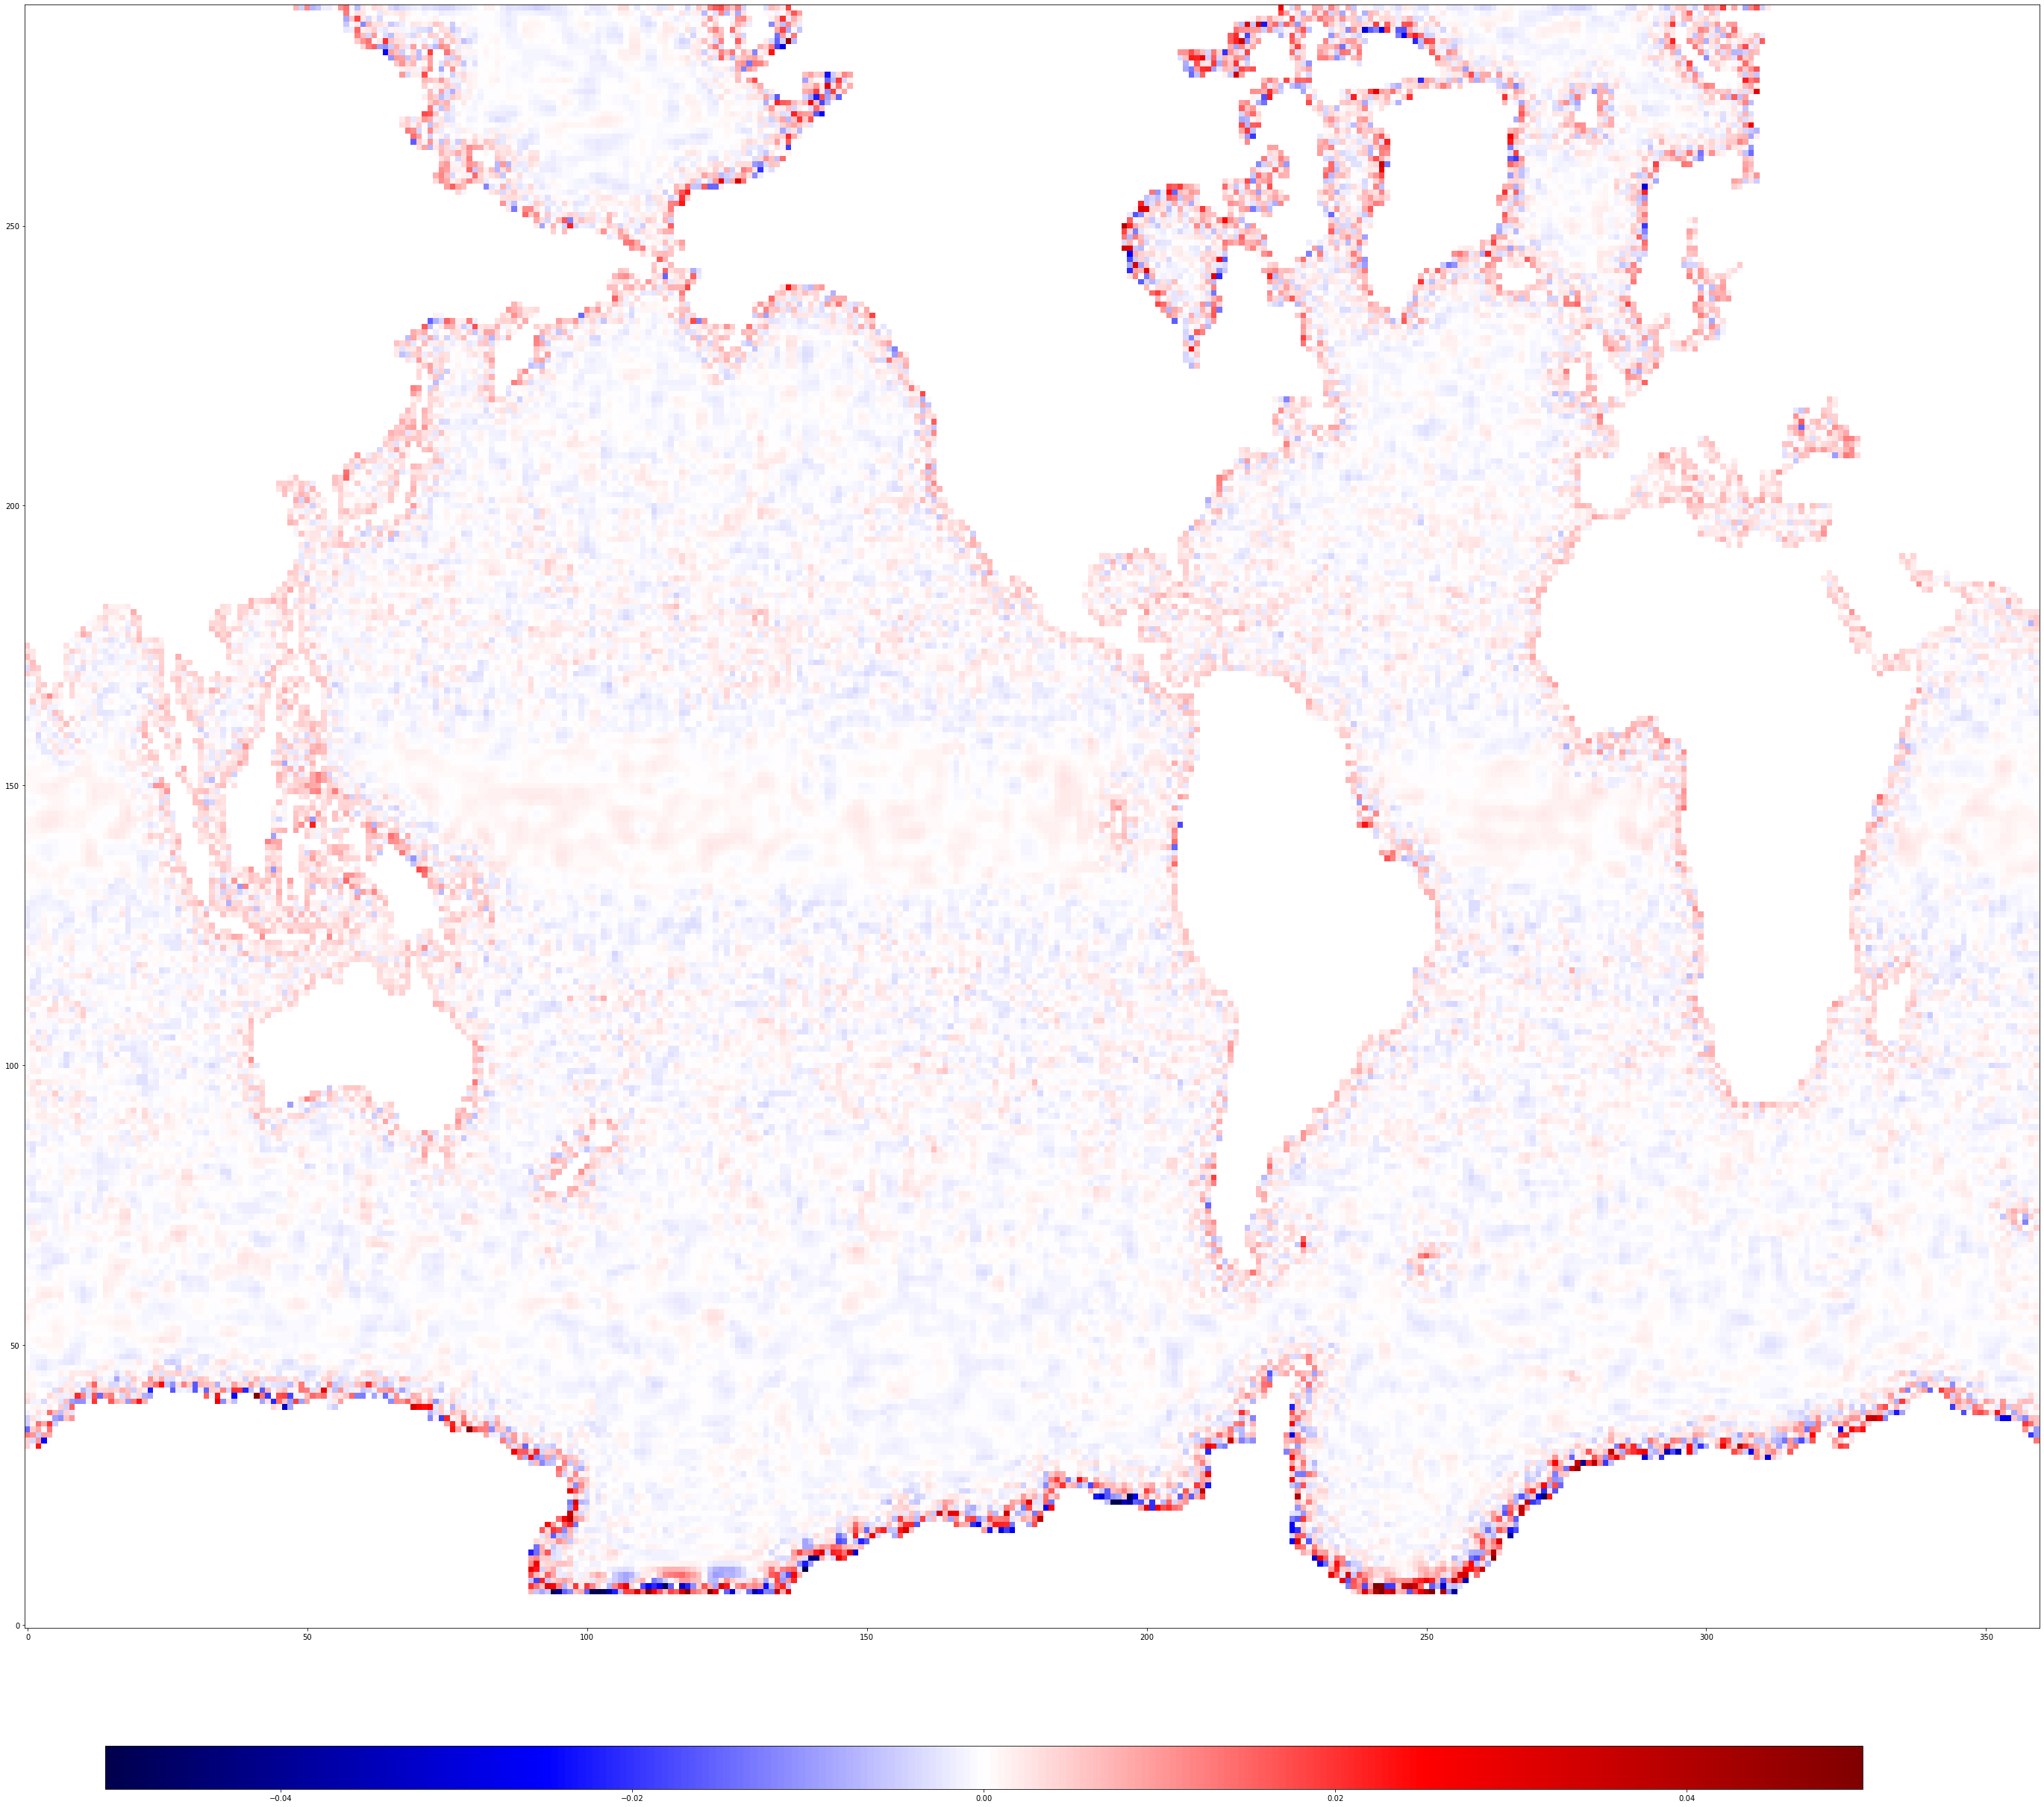

In [8]:
model_path = "results/wandb/cnn/1_1_adam/checkpoints/epoch=45222-val_loss=0.00020.ckpt"
eps = compute_eps(X_train,Y_train,model_path)
fig,axs = plt.subplots(figsize=size_im,ncols=1)
c = axs.imshow(eps,origin="lower",vmin=-0.05,vmax=0.05,cmap="seismic")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal', fraction=1)
plt.show()
fig.savefig(save_dir+"train/"+"1_1_adam")

mean:  0.0025421451423955016
max:  0.5093331194086483
min:  -0.3222118601702899


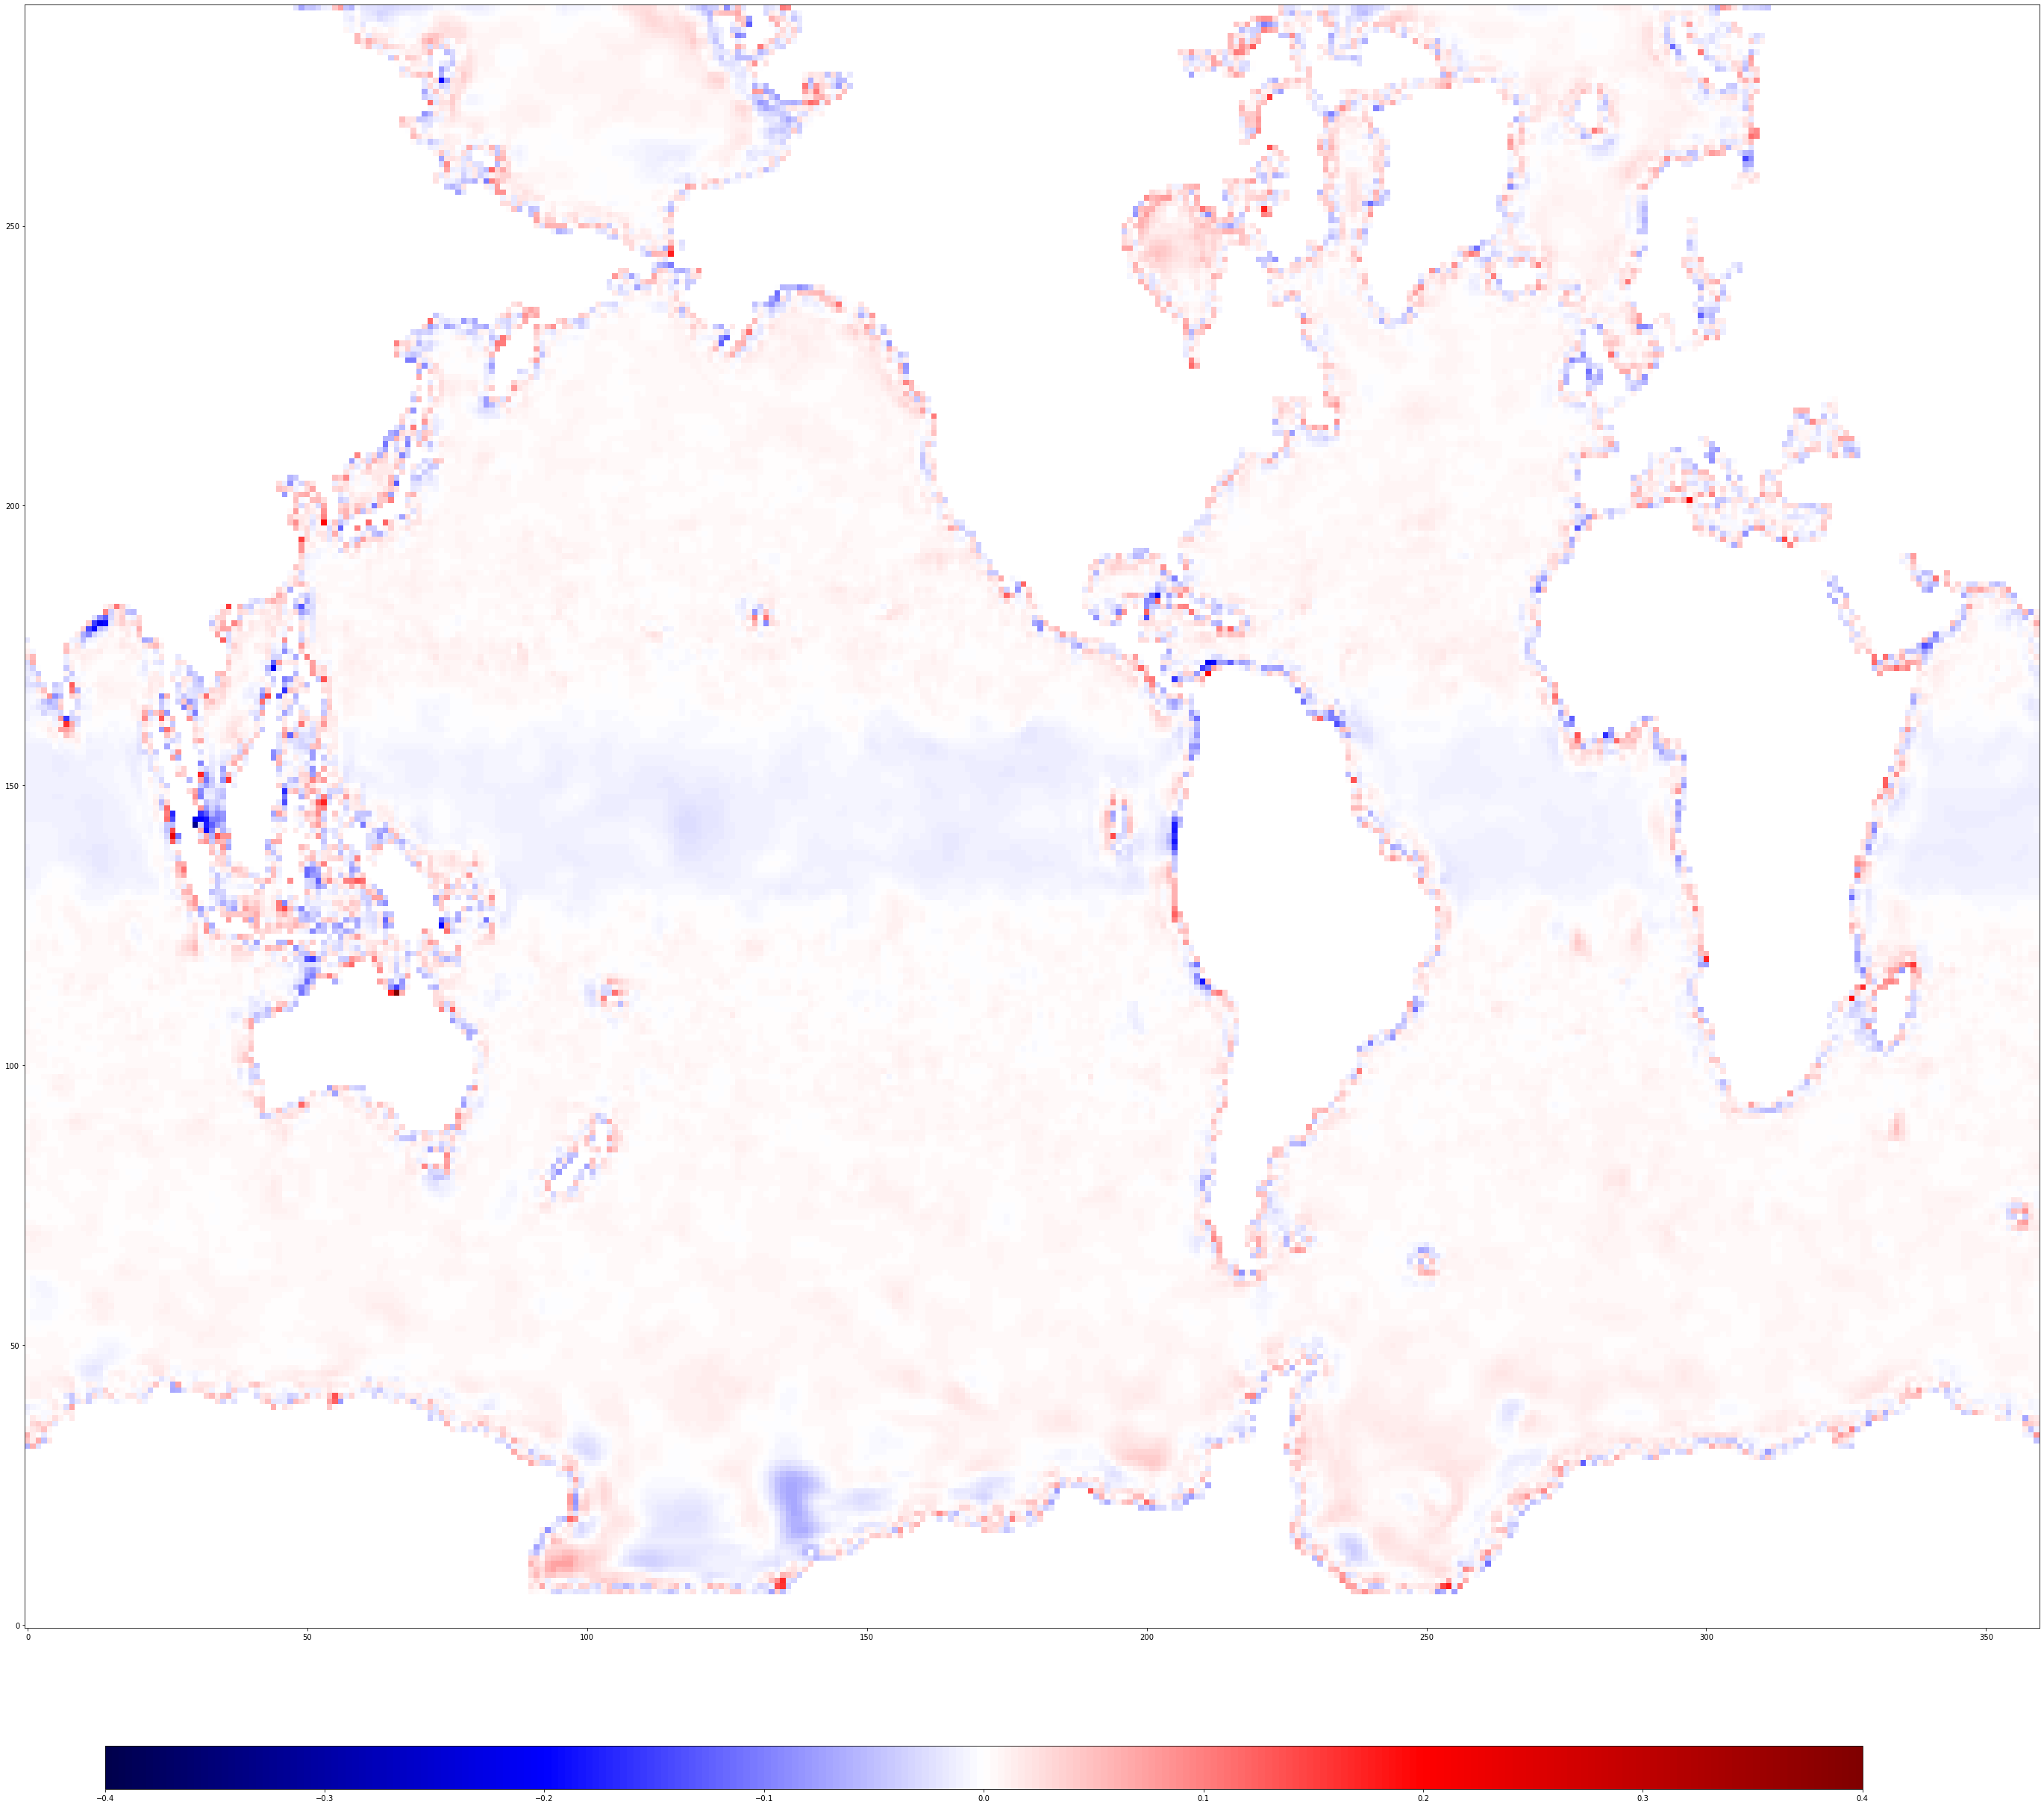

In [9]:
eps = compute_eps(X_valid,Y_valid,model_path)
fig,axs = plt.subplots(figsize=size_im,ncols=1)
c = axs.imshow(eps,origin="lower",vmin=-0.4,vmax=0.4,cmap="seismic")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()
fig.savefig(save_dir+"valid/"+"1_1_adam")

mean:  0.00045927388614126725
max:  0.07177531011118367
min:  -0.06435718568245595


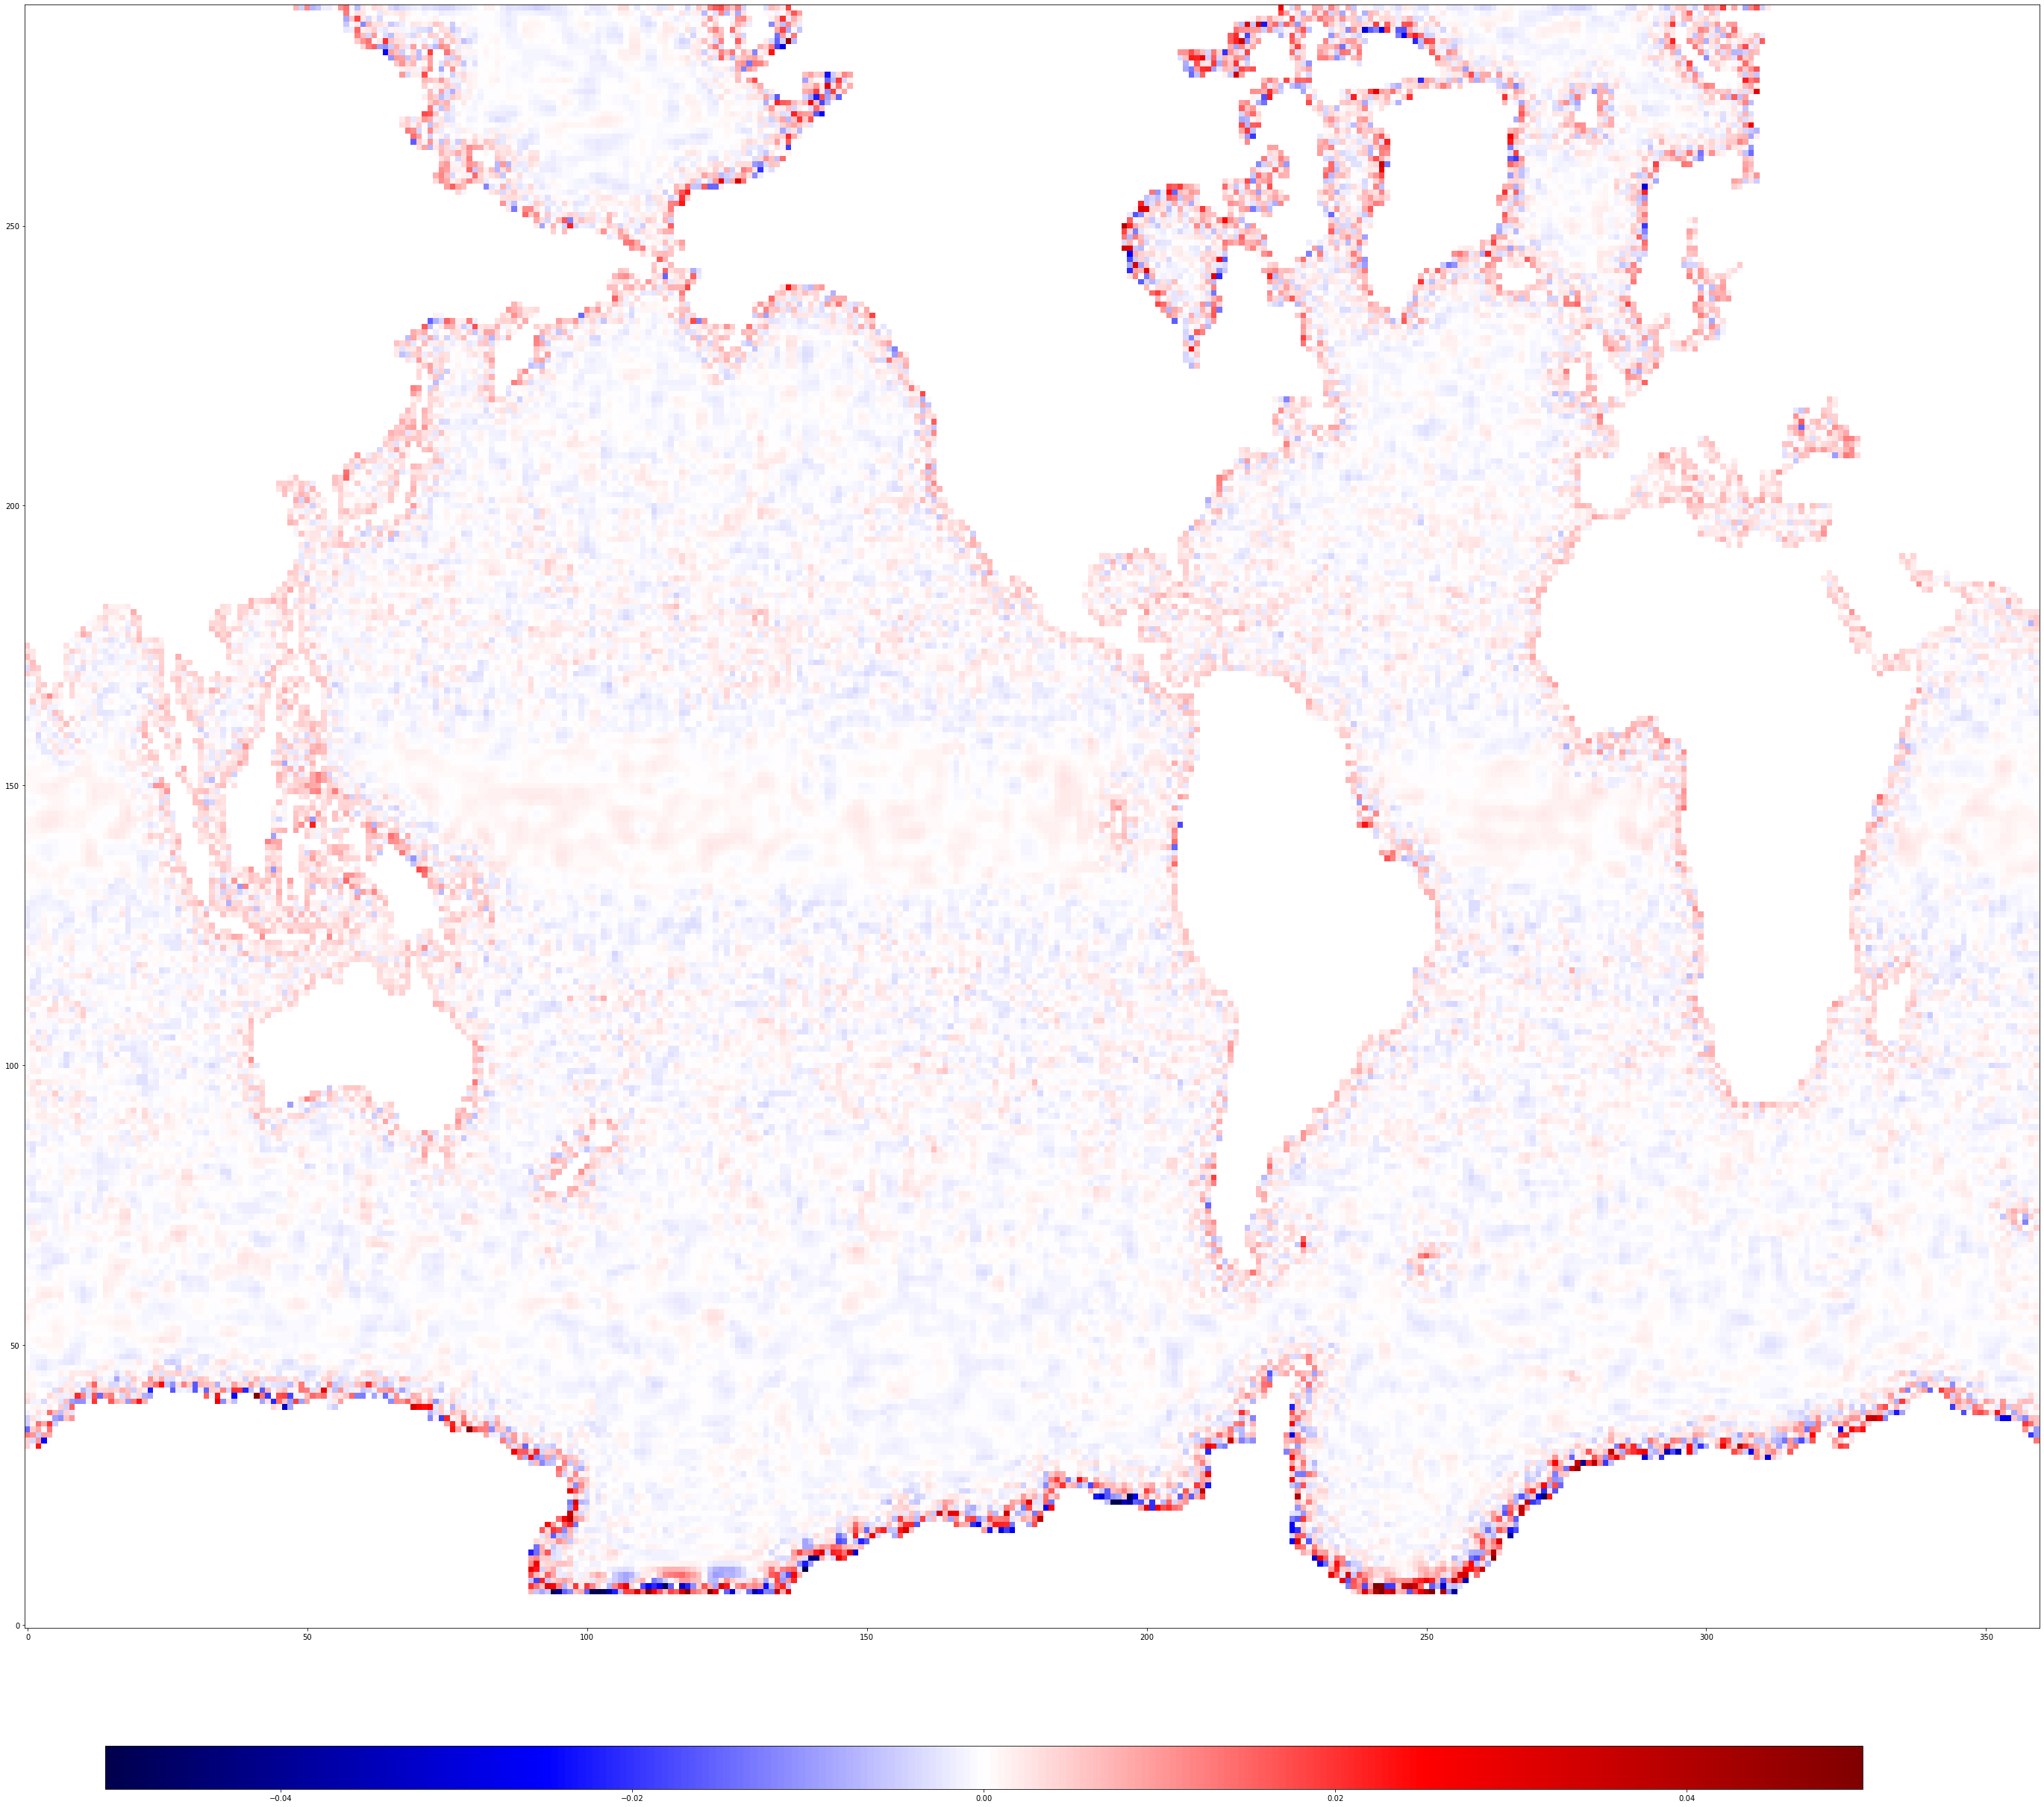

In [10]:
model = cnn.CNN.load_from_checkpoint("results/wandb/cnn/1_1_adamax/checkpoints/epoch=41104-val_loss=0.00040.ckpt")
eps = compute_eps(X_train,Y_train,model_path)
fig,axs = plt.subplots(figsize=size_im,ncols=1)
c = axs.imshow(eps,origin="lower",vmin=-0.05,vmax=0.05,cmap="seismic")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()
fig.savefig(save_dir+"train/"+"1_1_adamax")

mean:  0.0025421451423955016
max:  0.5093331194086483
min:  -0.3222118601702899


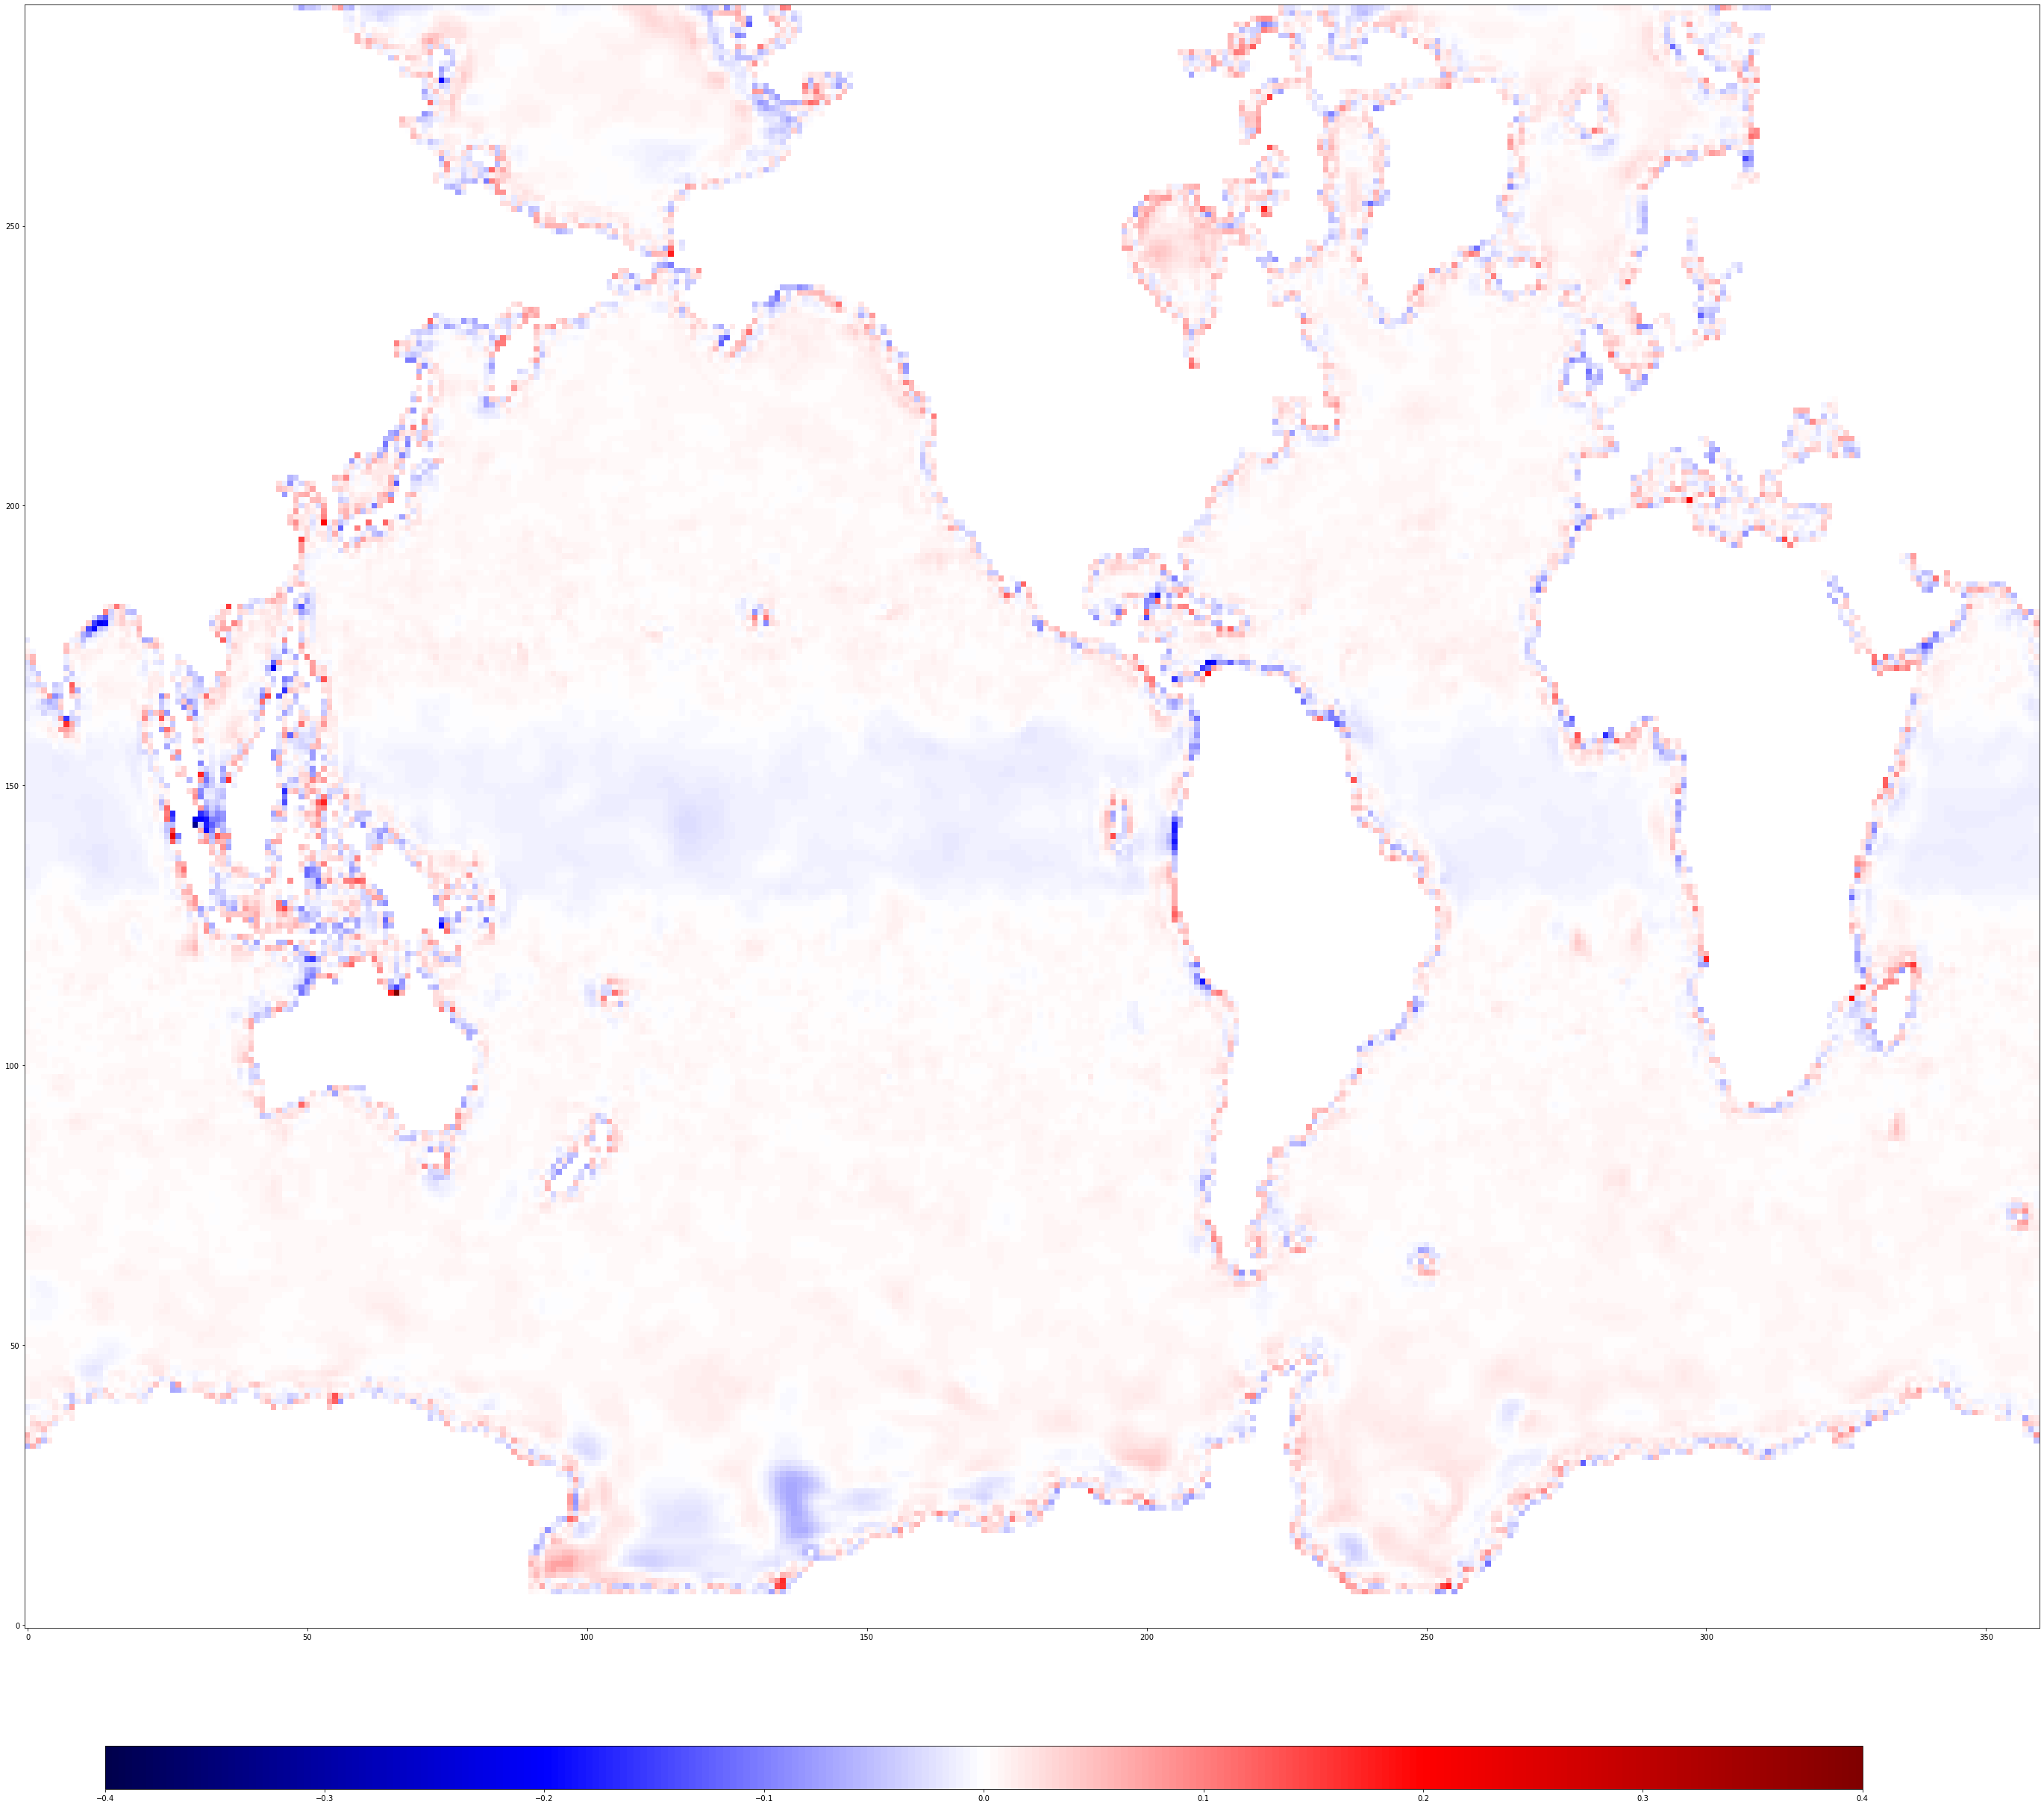

In [11]:
eps = compute_eps(X_valid,Y_valid,model_path)
fig,axs = plt.subplots(figsize=size_im,ncols=1)
c = axs.imshow(eps,origin="lower",vmin=-0.4,vmax=0.4,cmap="seismic")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()
fig.savefig(save_dir+"valid/"+"1_1_adamax")

mean:  -7.649590700918649e-05
max:  0.030516080832611175
min:  -0.022703616983051705


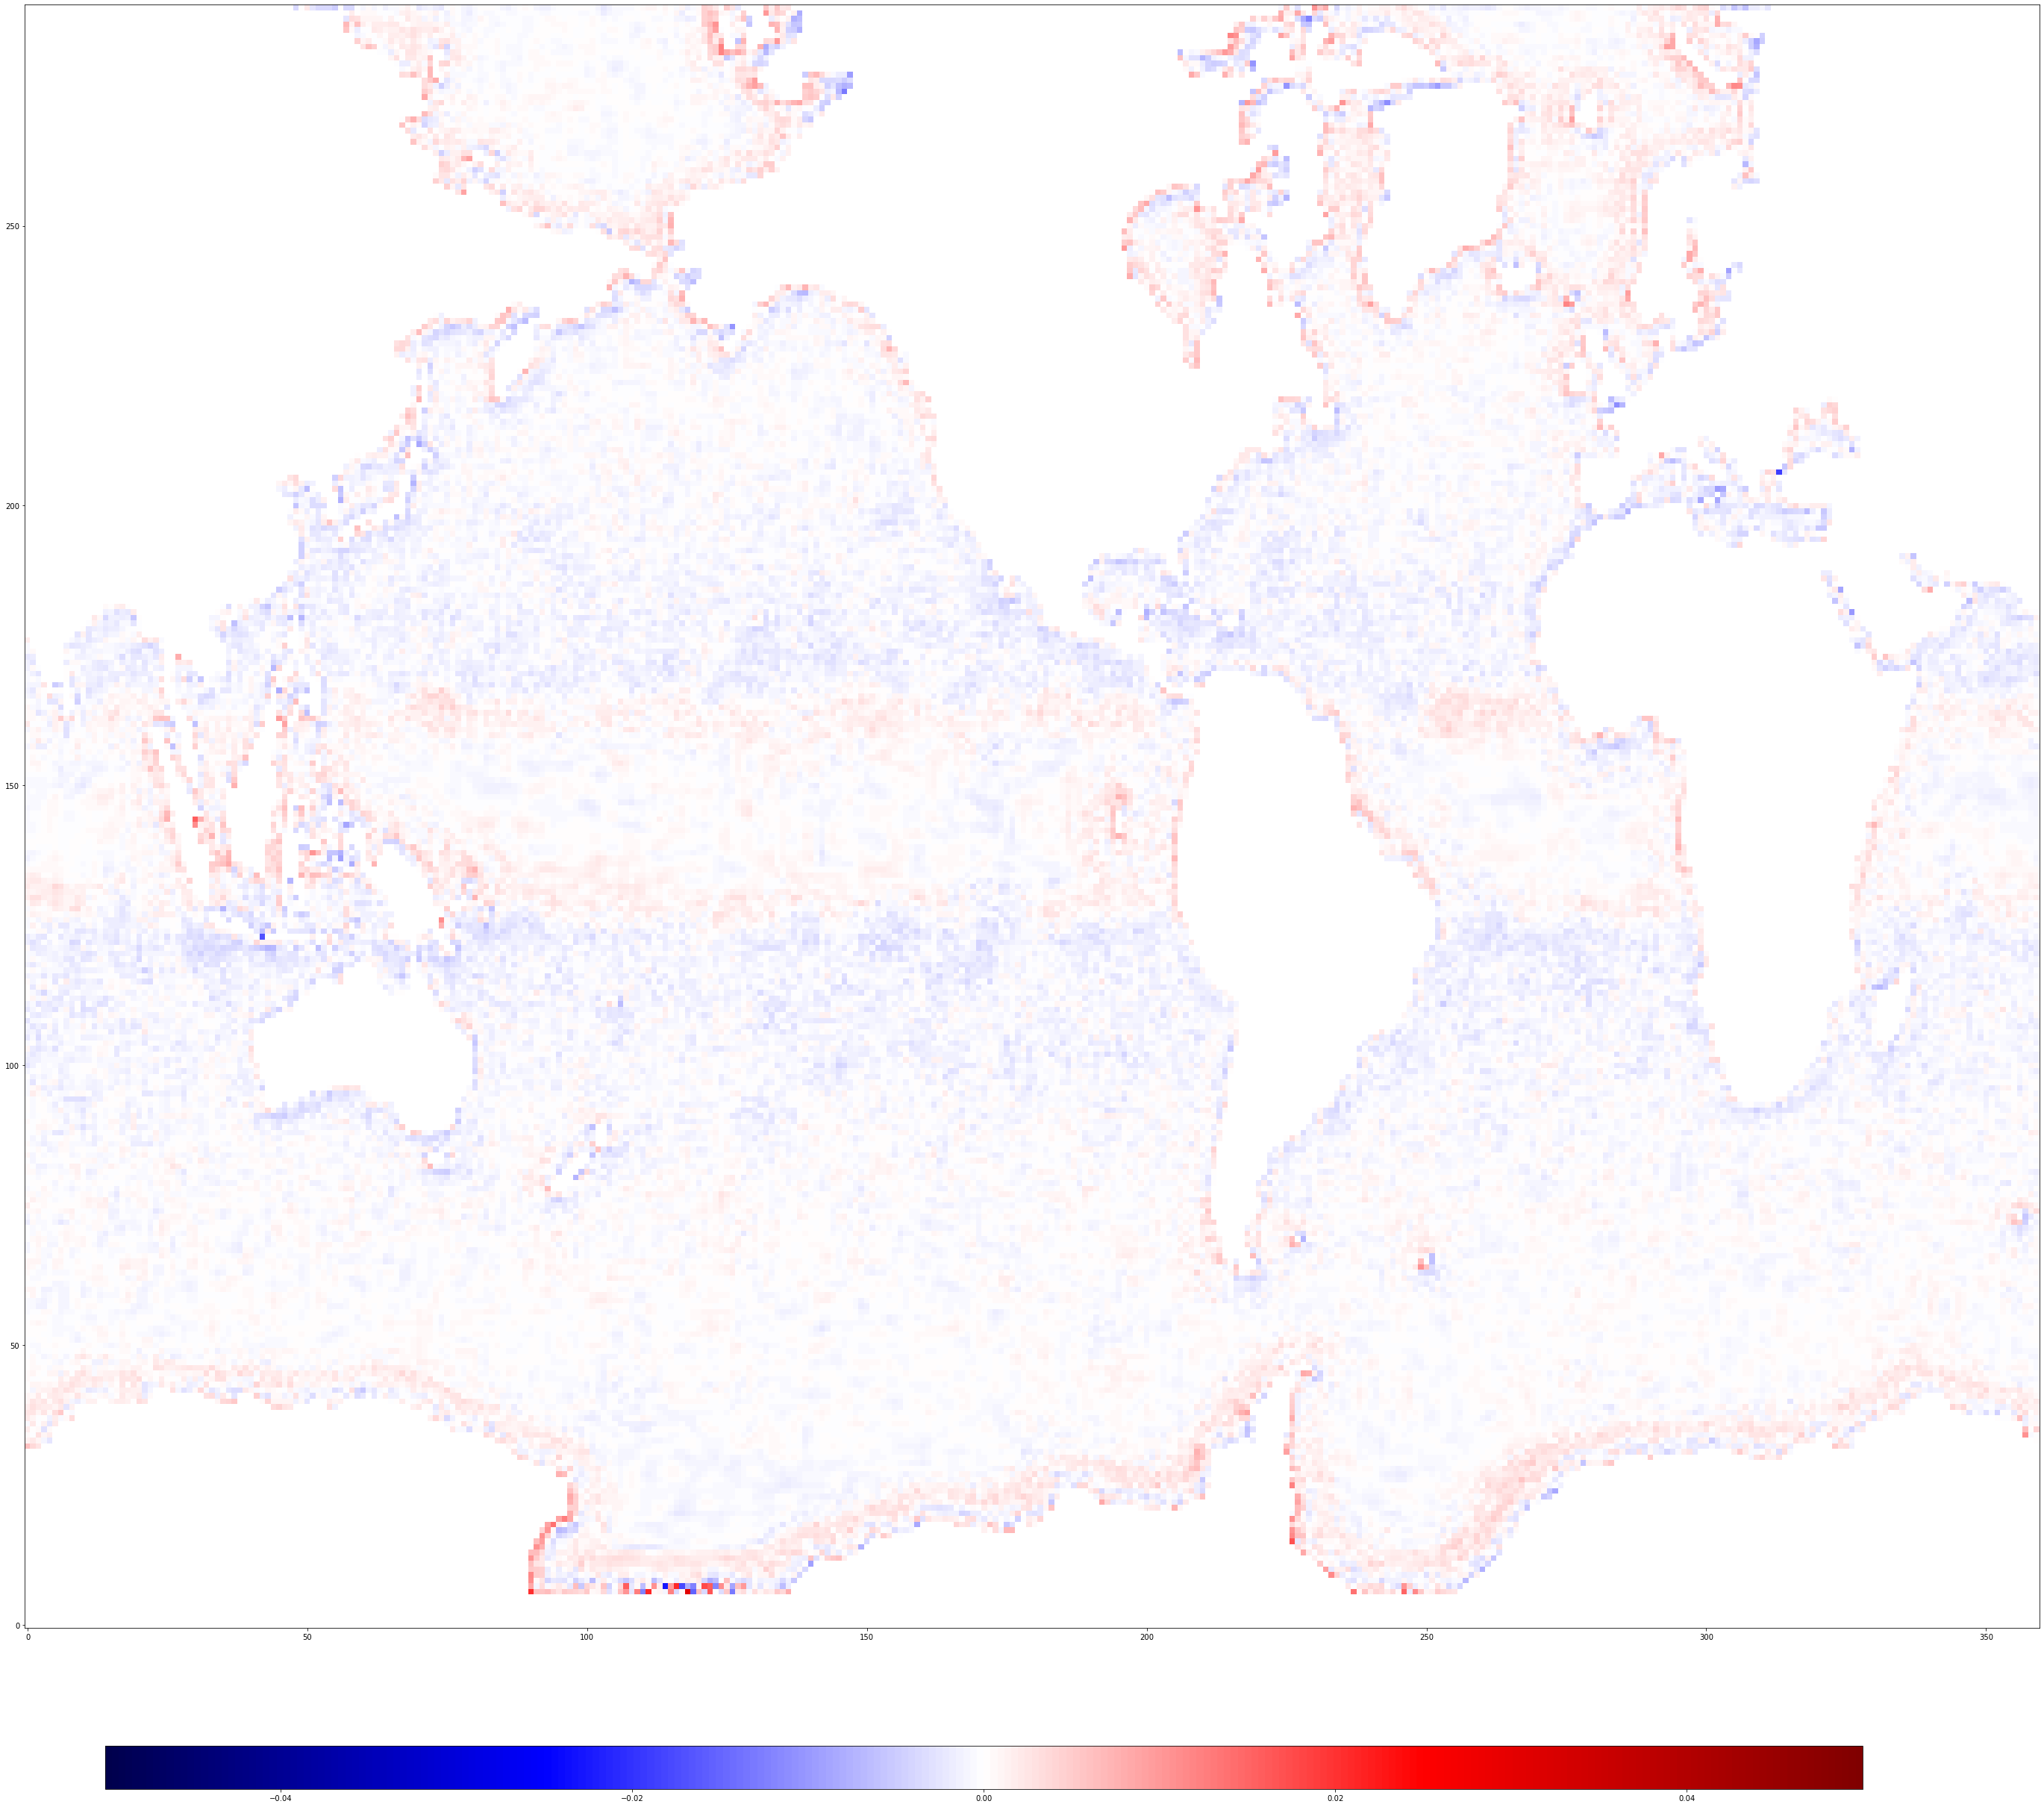

In [12]:
model_path = "results/wandb/cnn/1_1_eps_adamax/checkpoints/epoch=48842-val_loss=0.00048.ckpt"
eps = compute_eps(X_train,Y_train,model_path)
fig,axs = plt.subplots(figsize=size_im,ncols=1)
c = axs.imshow(eps,origin="lower",vmin=-0.05,vmax=0.05,cmap="seismic")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()
fig.savefig(save_dir+"train/"+"1_1_eps_adamax")

mean:  0.0032374074350774423
max:  0.32221014132452797
min:  -0.47545781983014773


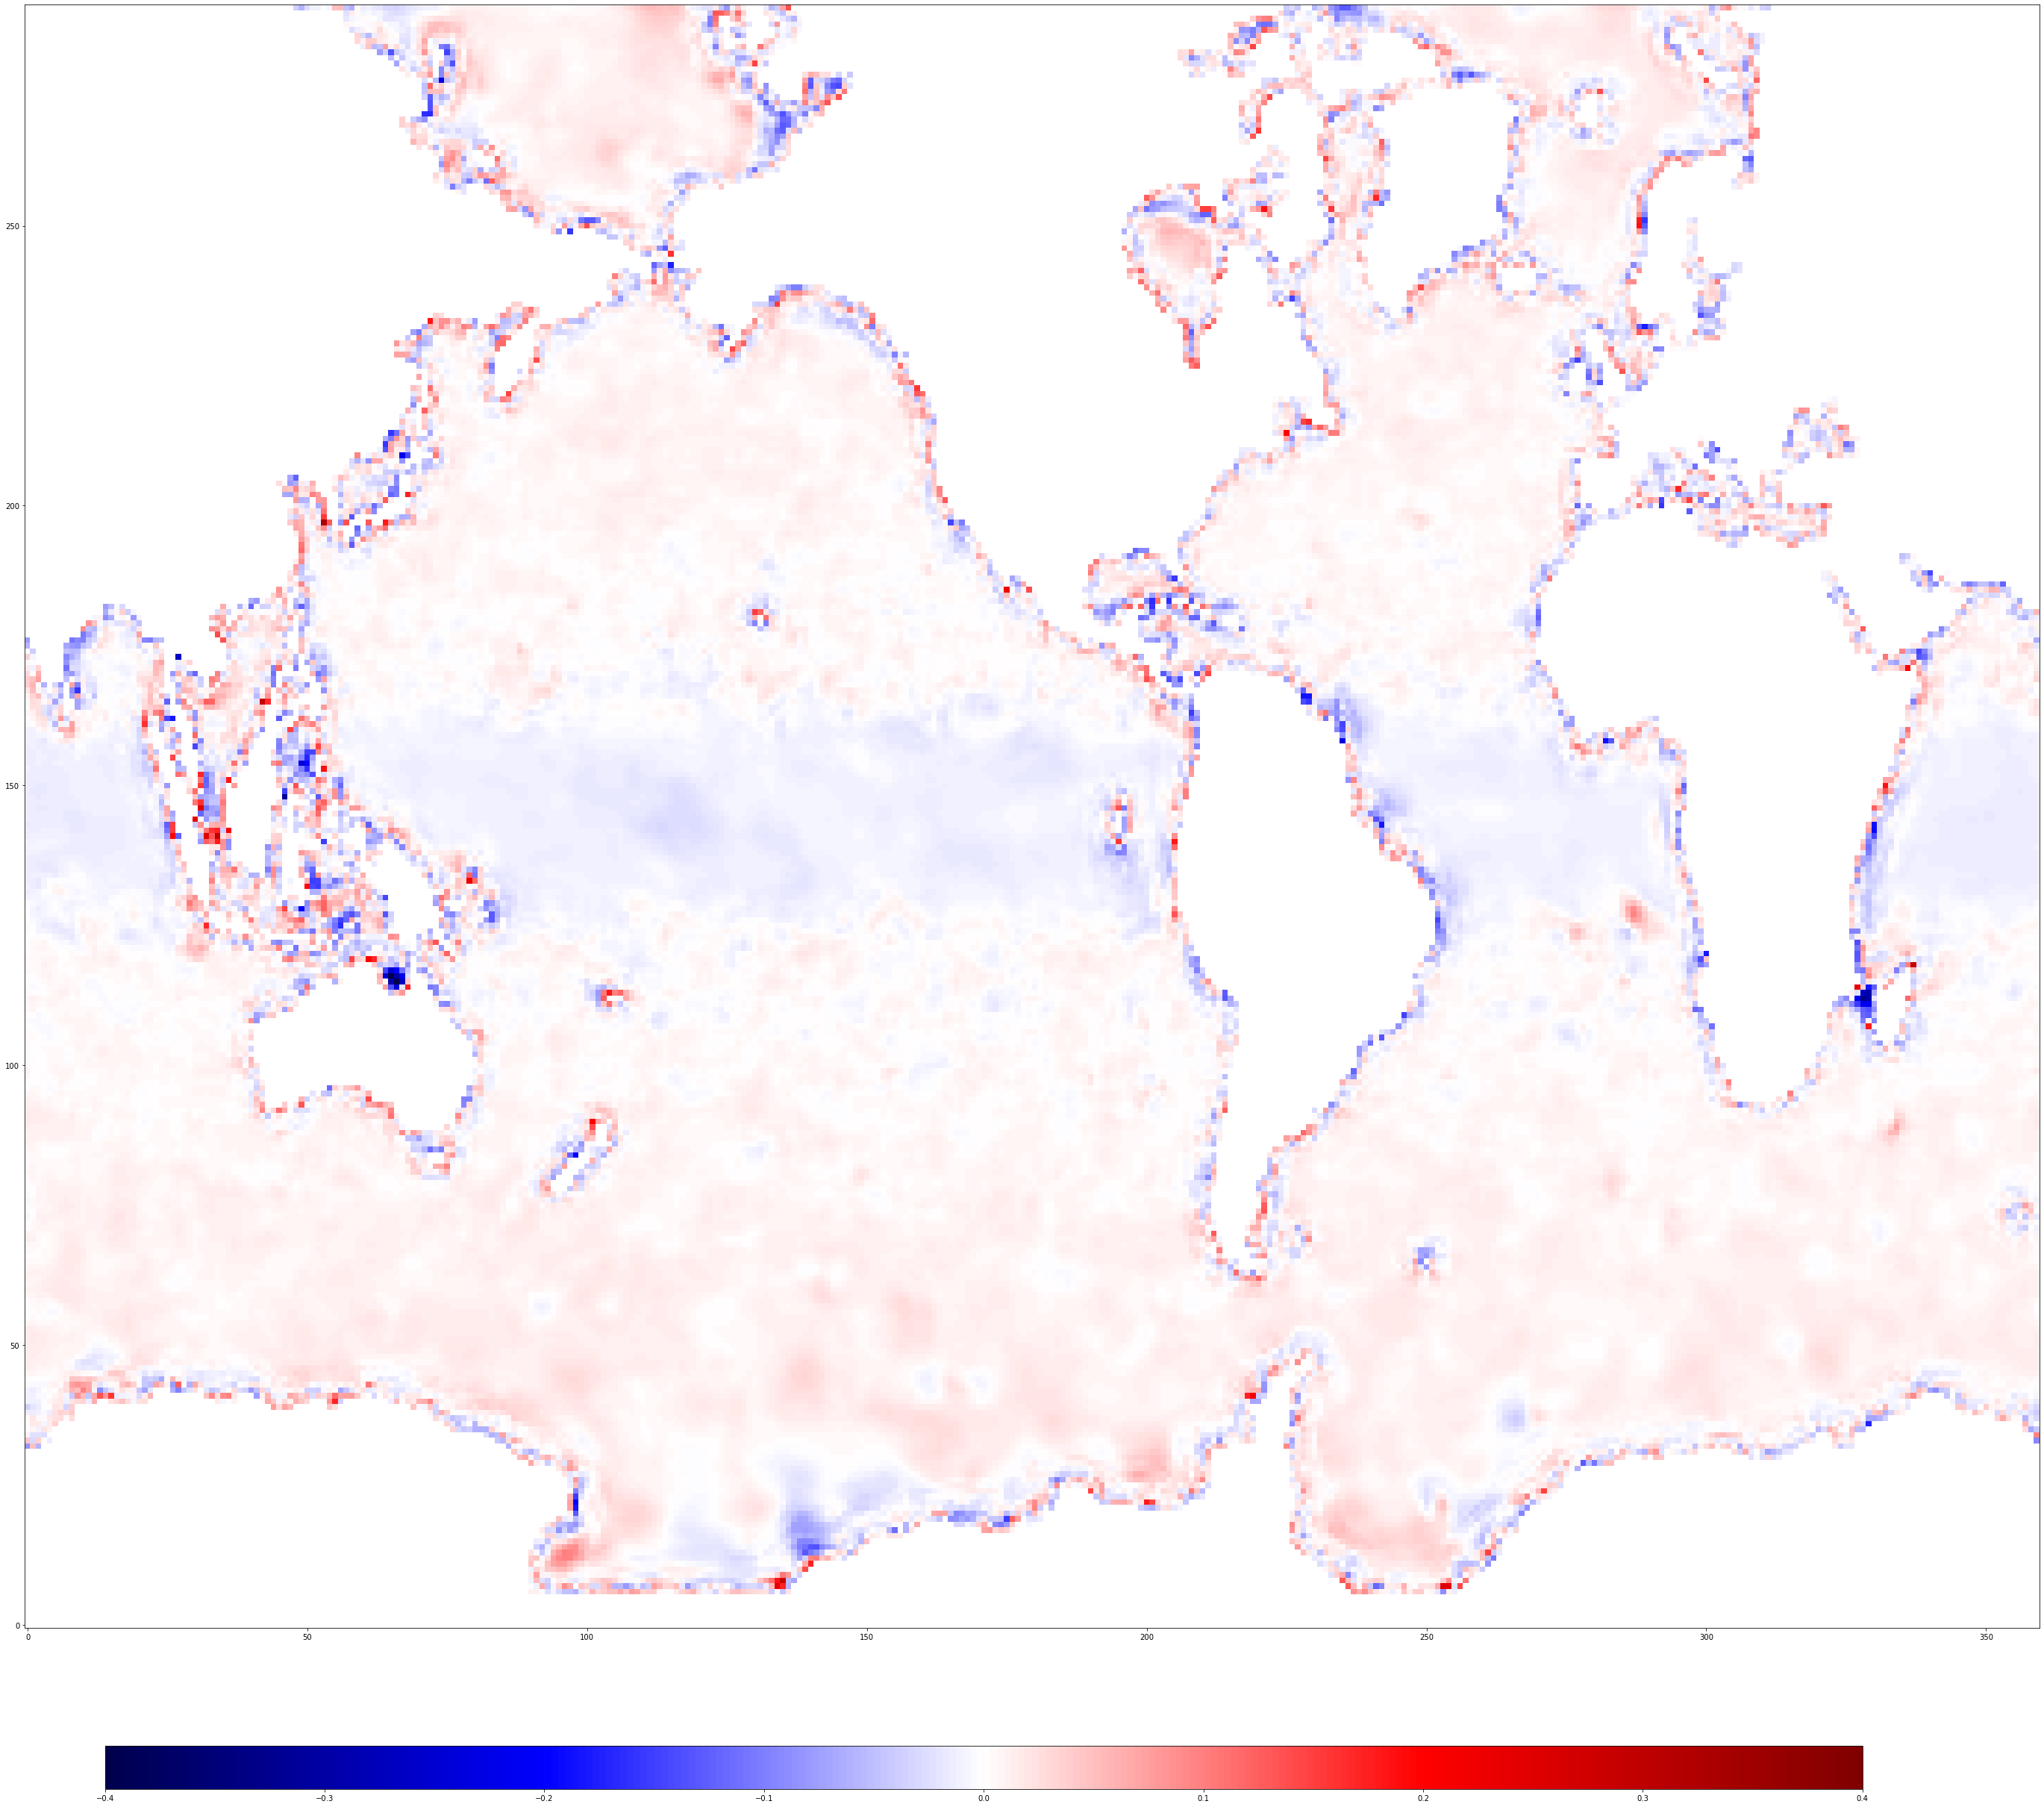

In [13]:
eps = compute_eps(X_valid,Y_valid,model_path)
fig,axs = plt.subplots(figsize=size_im,ncols=1)
c = axs.imshow(eps,origin="lower",vmin=-0.4,vmax=0.4,cmap="seismic")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()
fig.savefig(save_dir+"valid/"+"1_1_eps_adamax")

mean:  0.00014153534327580918
max:  0.057790124992394436
min:  -0.05782748024698873


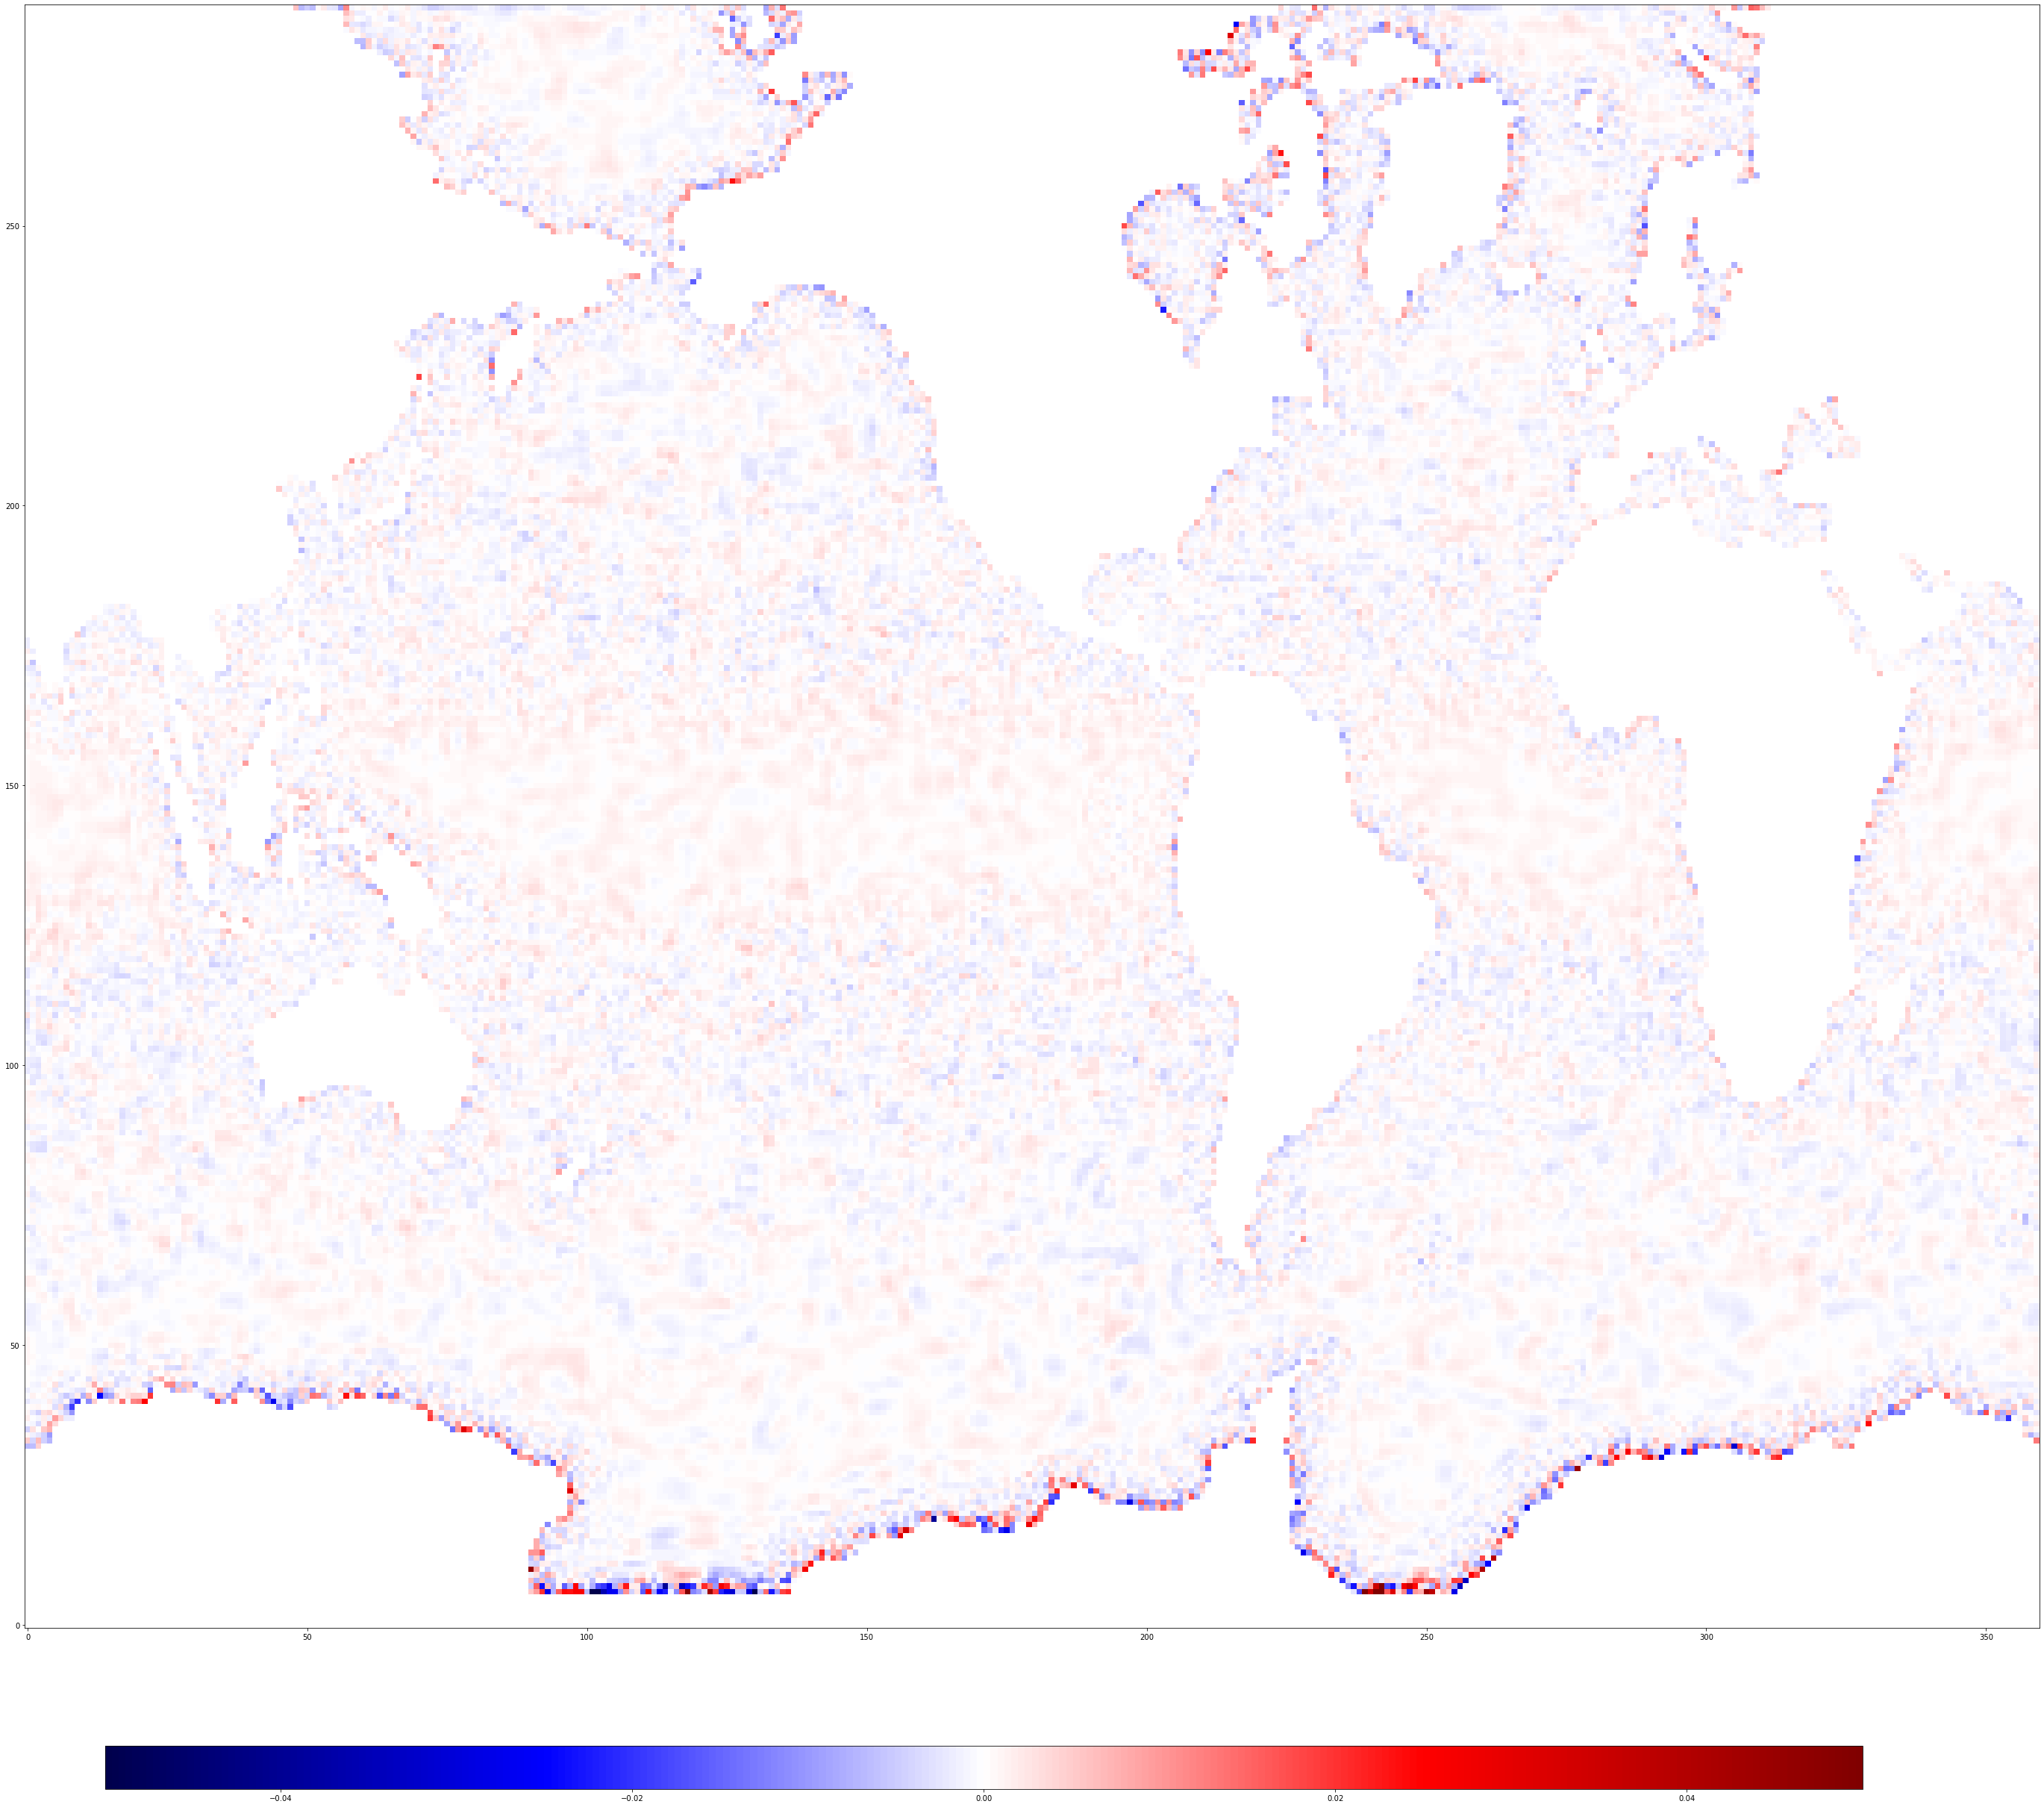

In [14]:
model_path = "results/wandb/cnn/1_1_adam_map/checkpoints/epoch=42198-val_loss=0.00018.ckpt"
eps = compute_eps(X_train,Y_train,model_path,True,distance_map)
fig,axs = plt.subplots(figsize=size_im,ncols=1)
c = axs.imshow(eps,origin="lower",vmin=-0.05,vmax=0.05,cmap="seismic")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()
fig.savefig(save_dir+"train/"+"1_1_adam_map")

mean:  0.0030596934932278683
max:  0.2642012555200171
min:  -0.24837986848645513


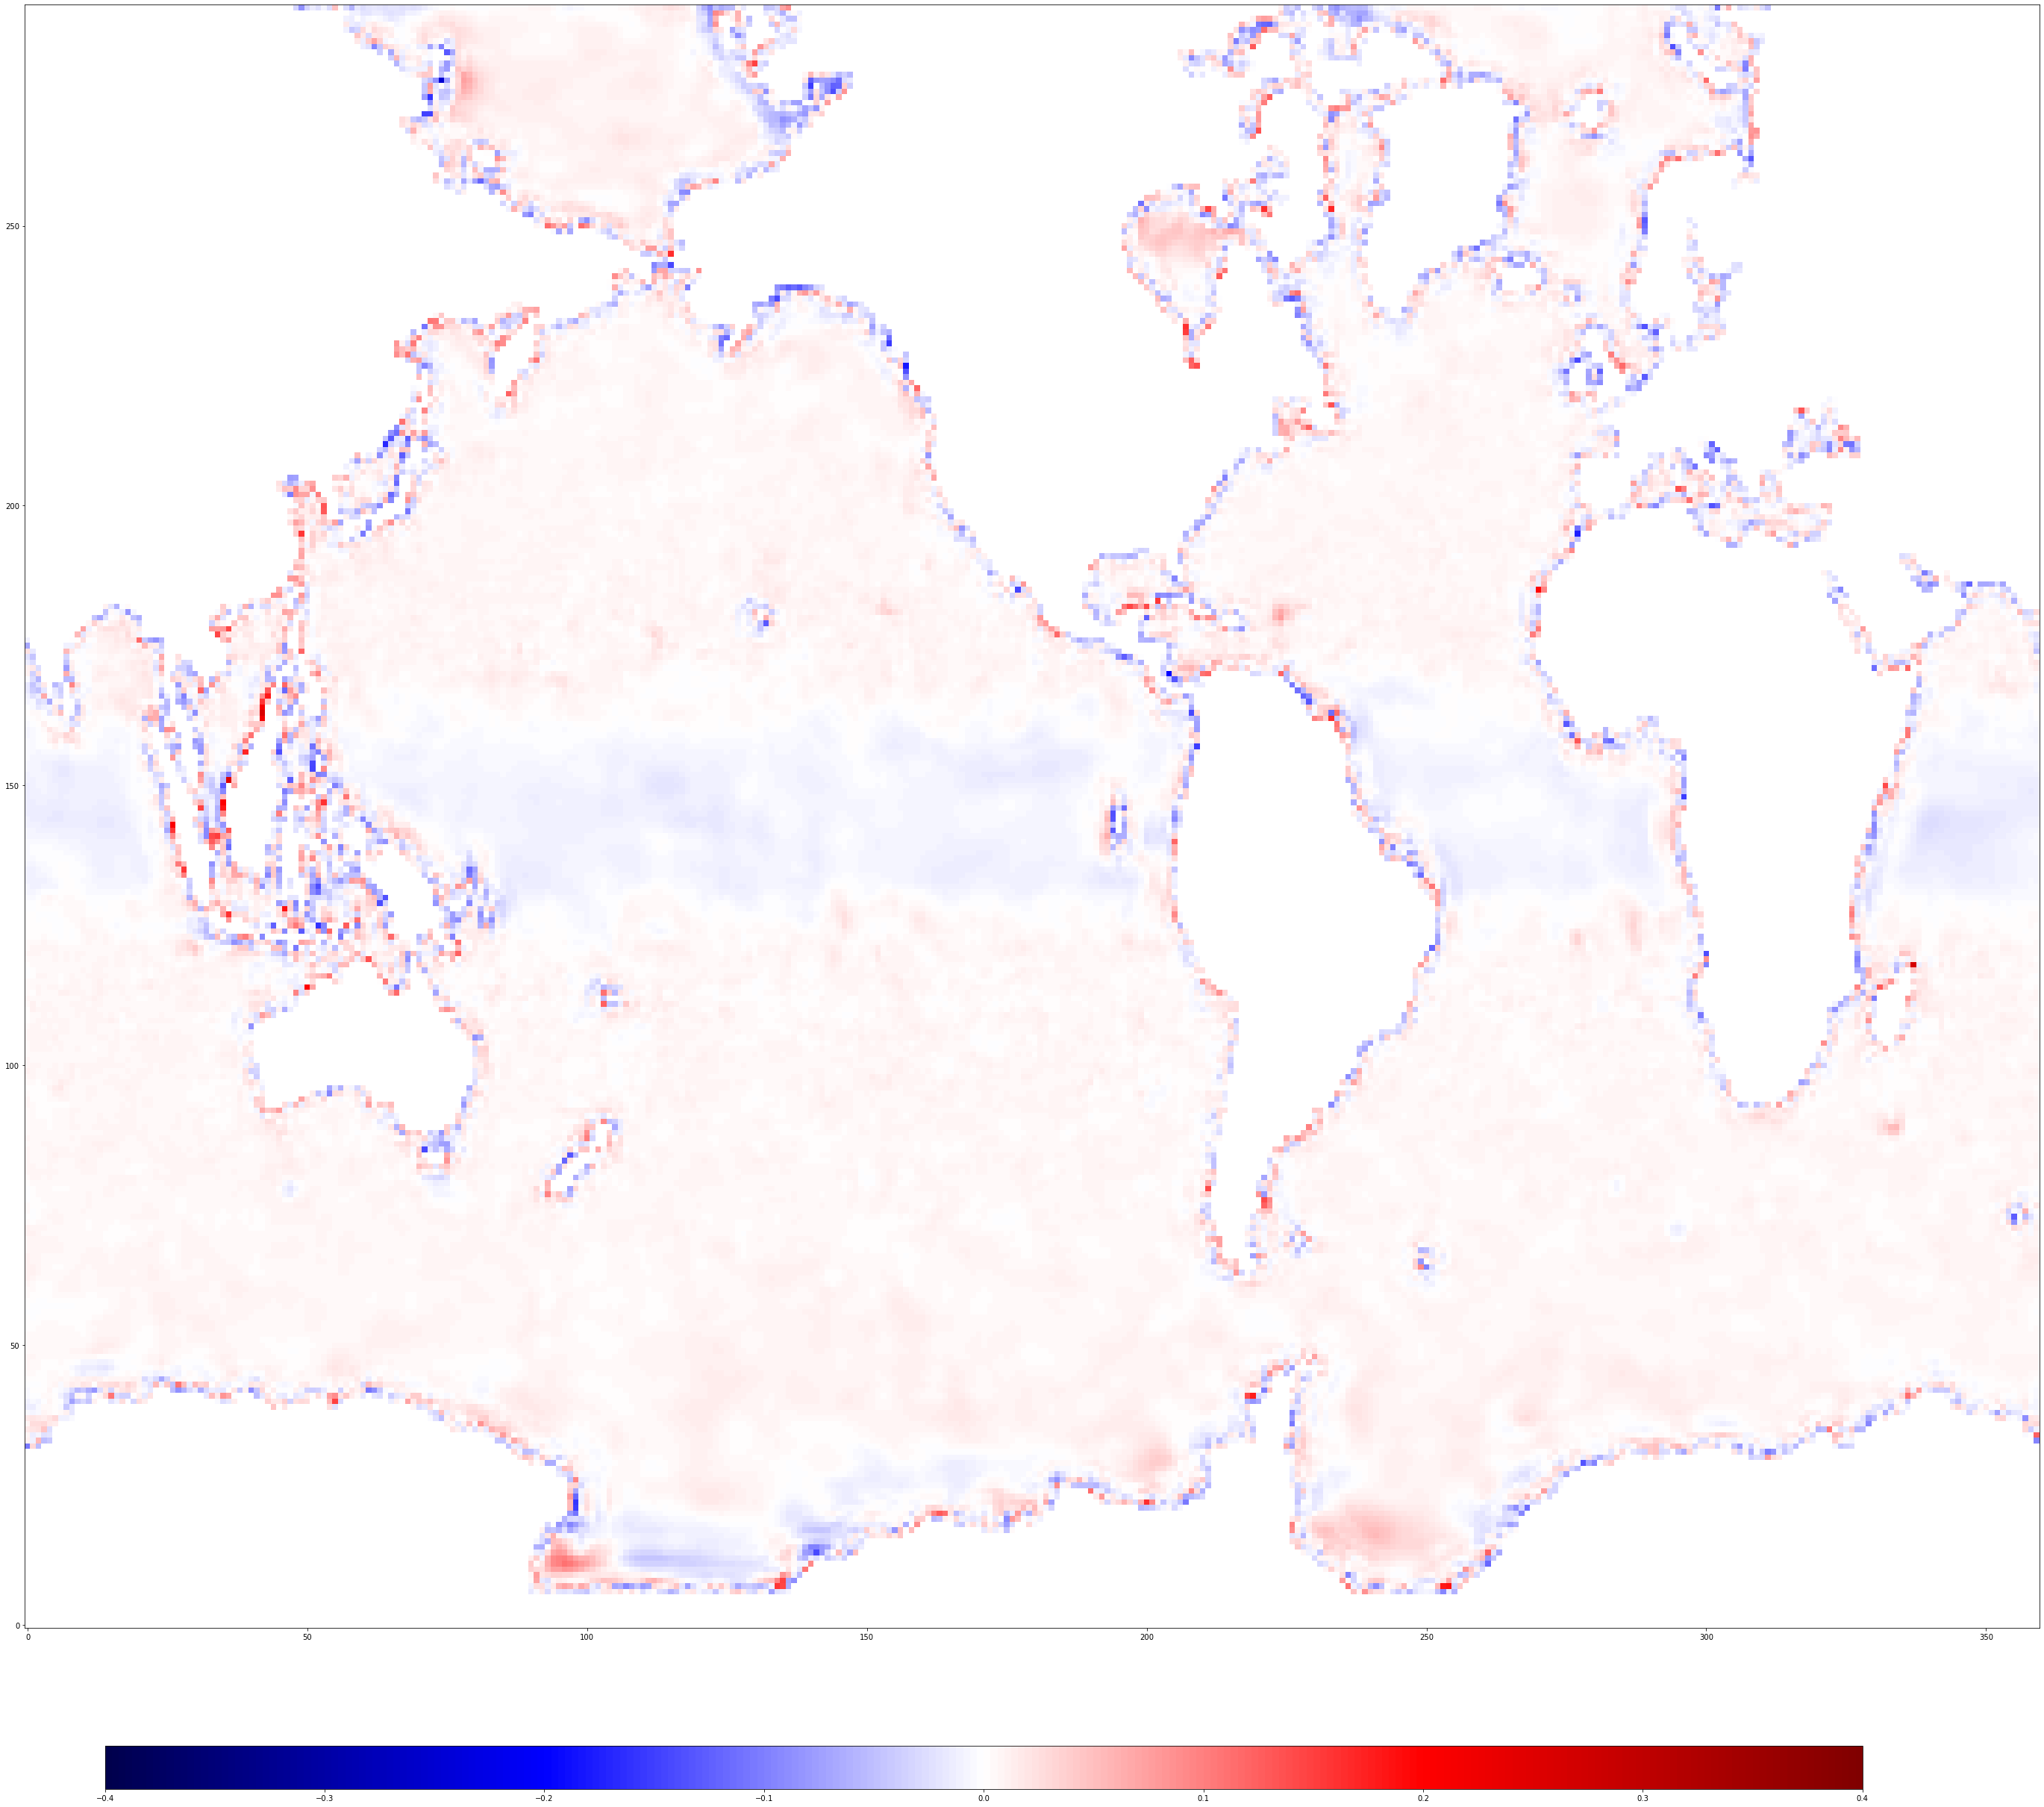

In [15]:
eps = compute_eps(X_valid,Y_valid,model_path,True,distance_map)
fig,axs = plt.subplots(figsize=size_im,ncols=1)
c = axs.imshow(eps,origin="lower",vmin=-0.4,vmax=0.4,cmap="seismic")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()
fig.savefig(save_dir+"valid/"+"1_1_adam_map")

mean:  -1.4278524849224406e-05
max:  0.08058215663146333
min:  -0.053216003818498045


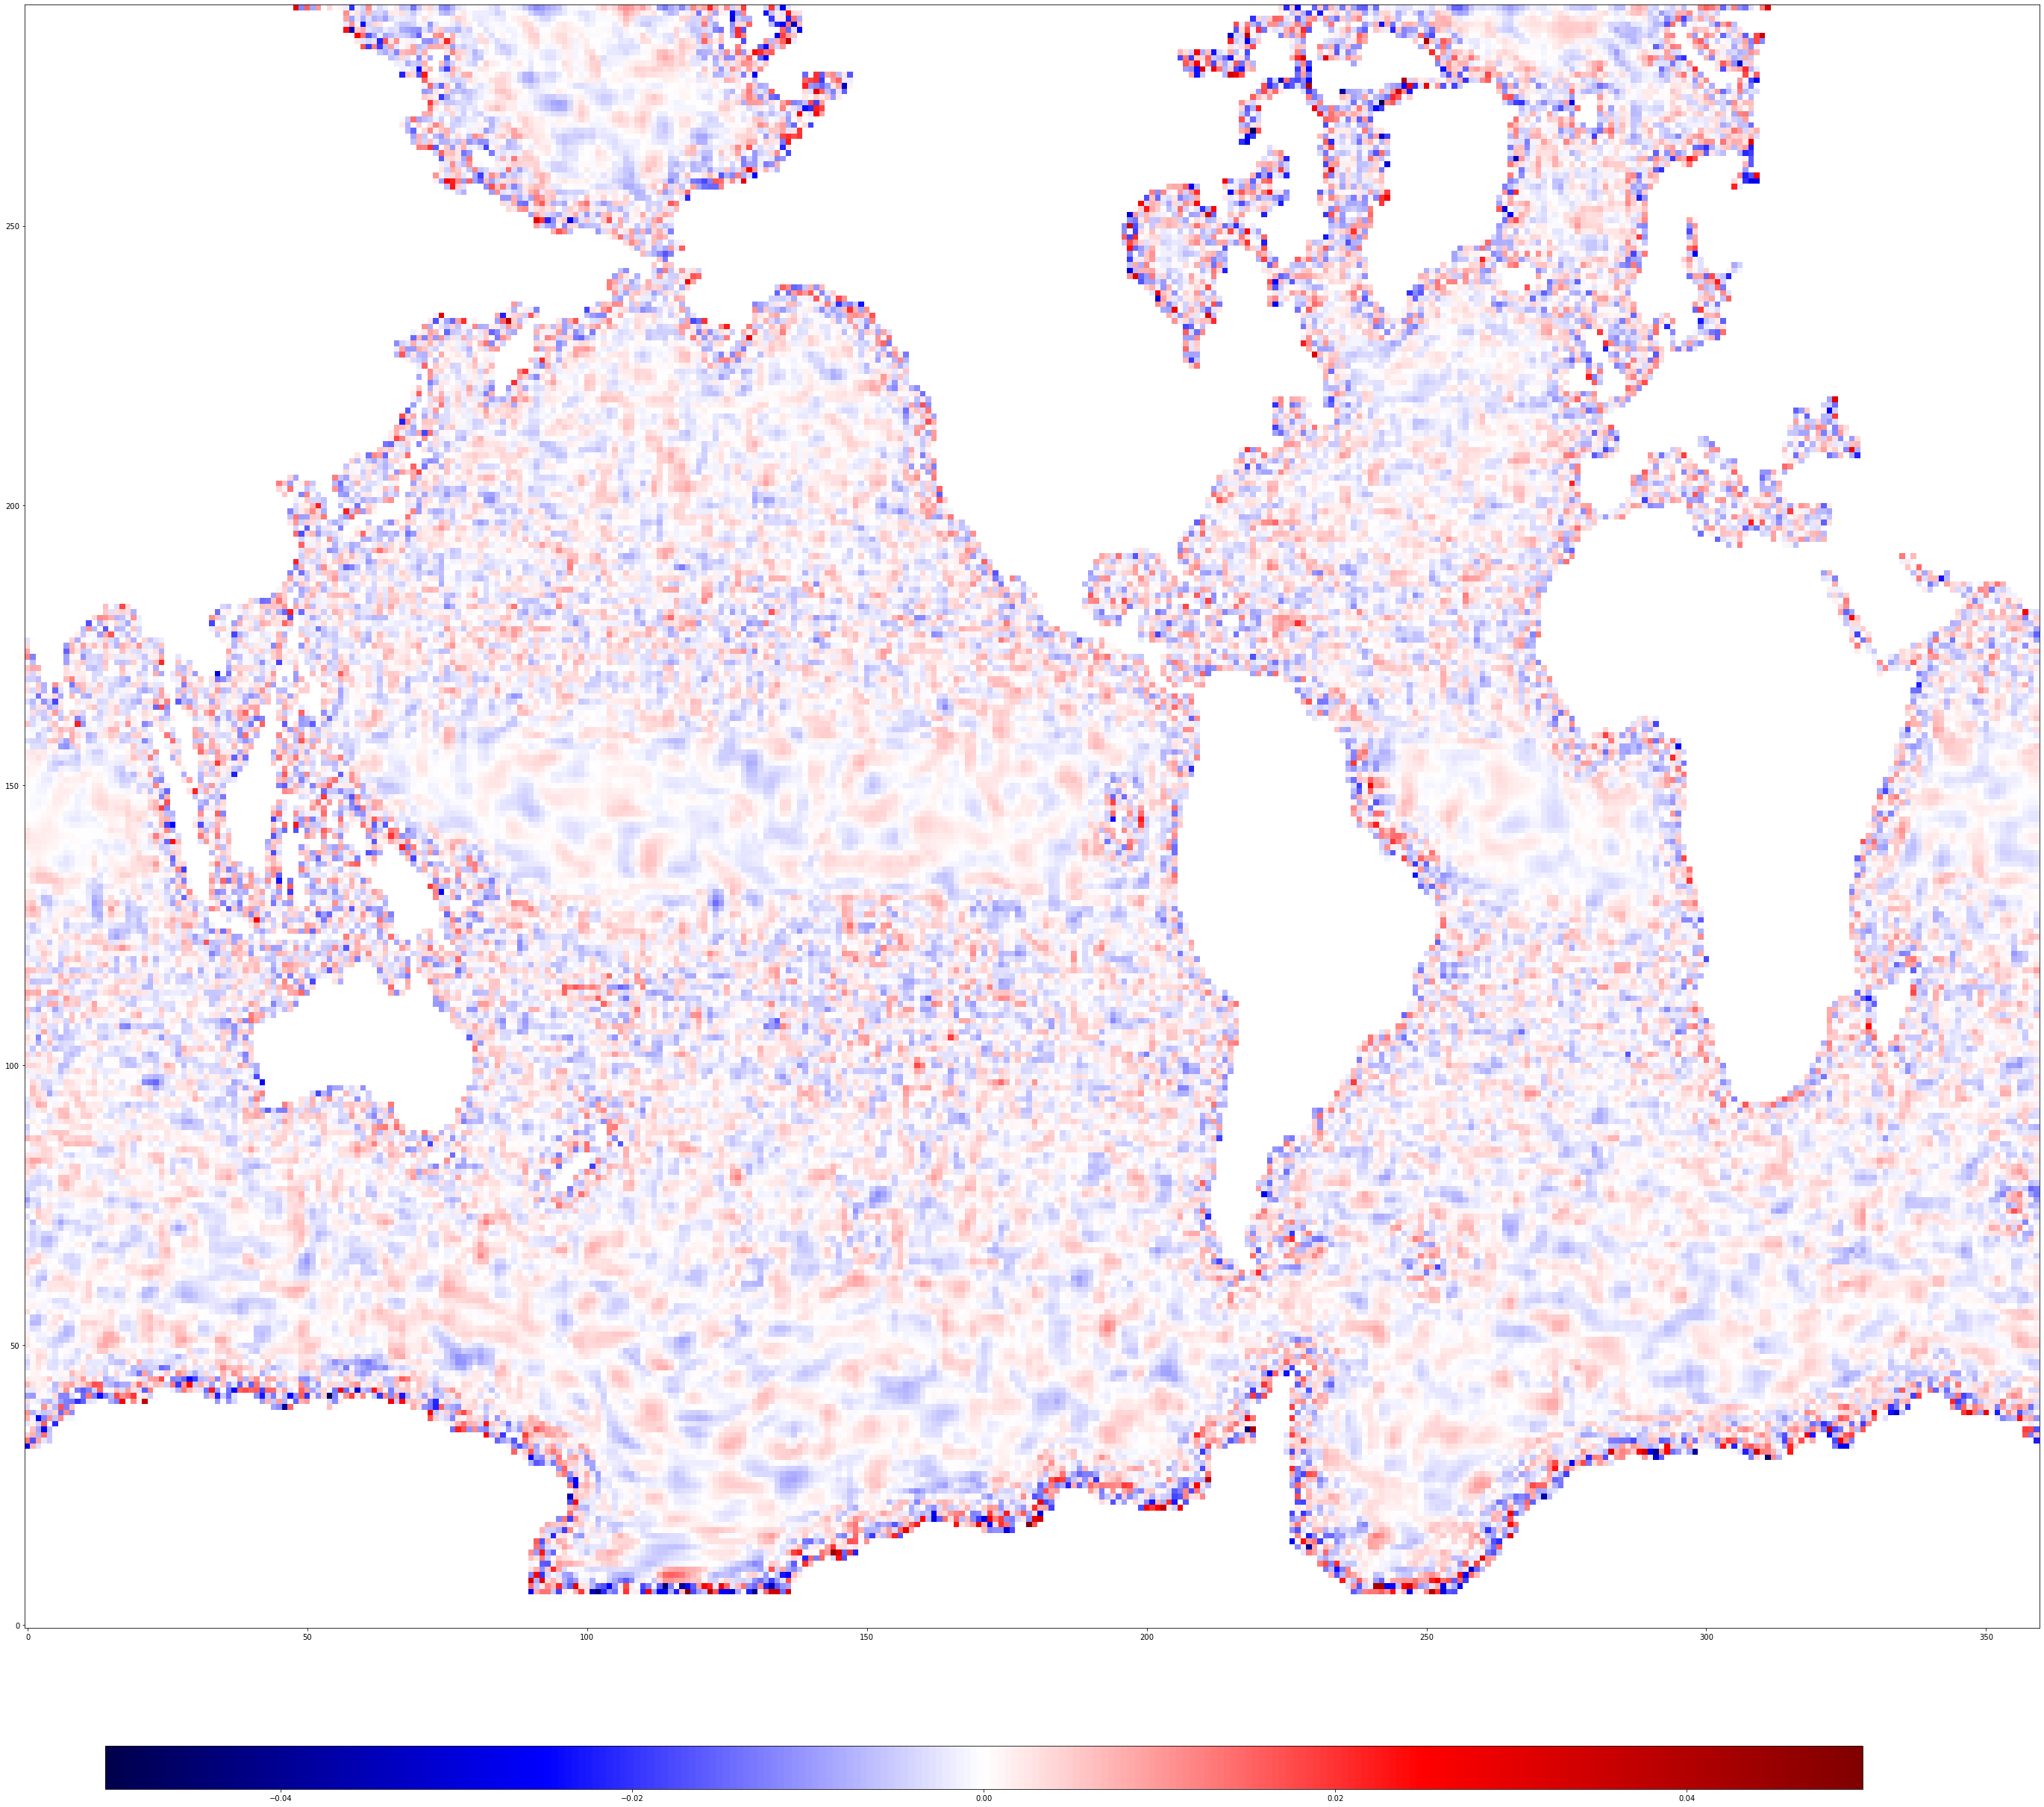

In [16]:
model_path = "results/wandb/cnn/1_1_eps_adamax_map/checkpoints/epoch=22059-val_loss=0.00045.ckpt"
eps = compute_eps(X_train,Y_train,model_path,True,distance_map)
fig,axs = plt.subplots(figsize=size_im,ncols=1)
c = axs.imshow(eps,origin="lower",vmin=-0.05,vmax=0.05,cmap="seismic")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()
fig.savefig(save_dir+"train/"+"1_1_eps_adamax_map")

mean:  0.0032543785245642766
max:  0.2983712934271842
min:  -0.2637905856252409


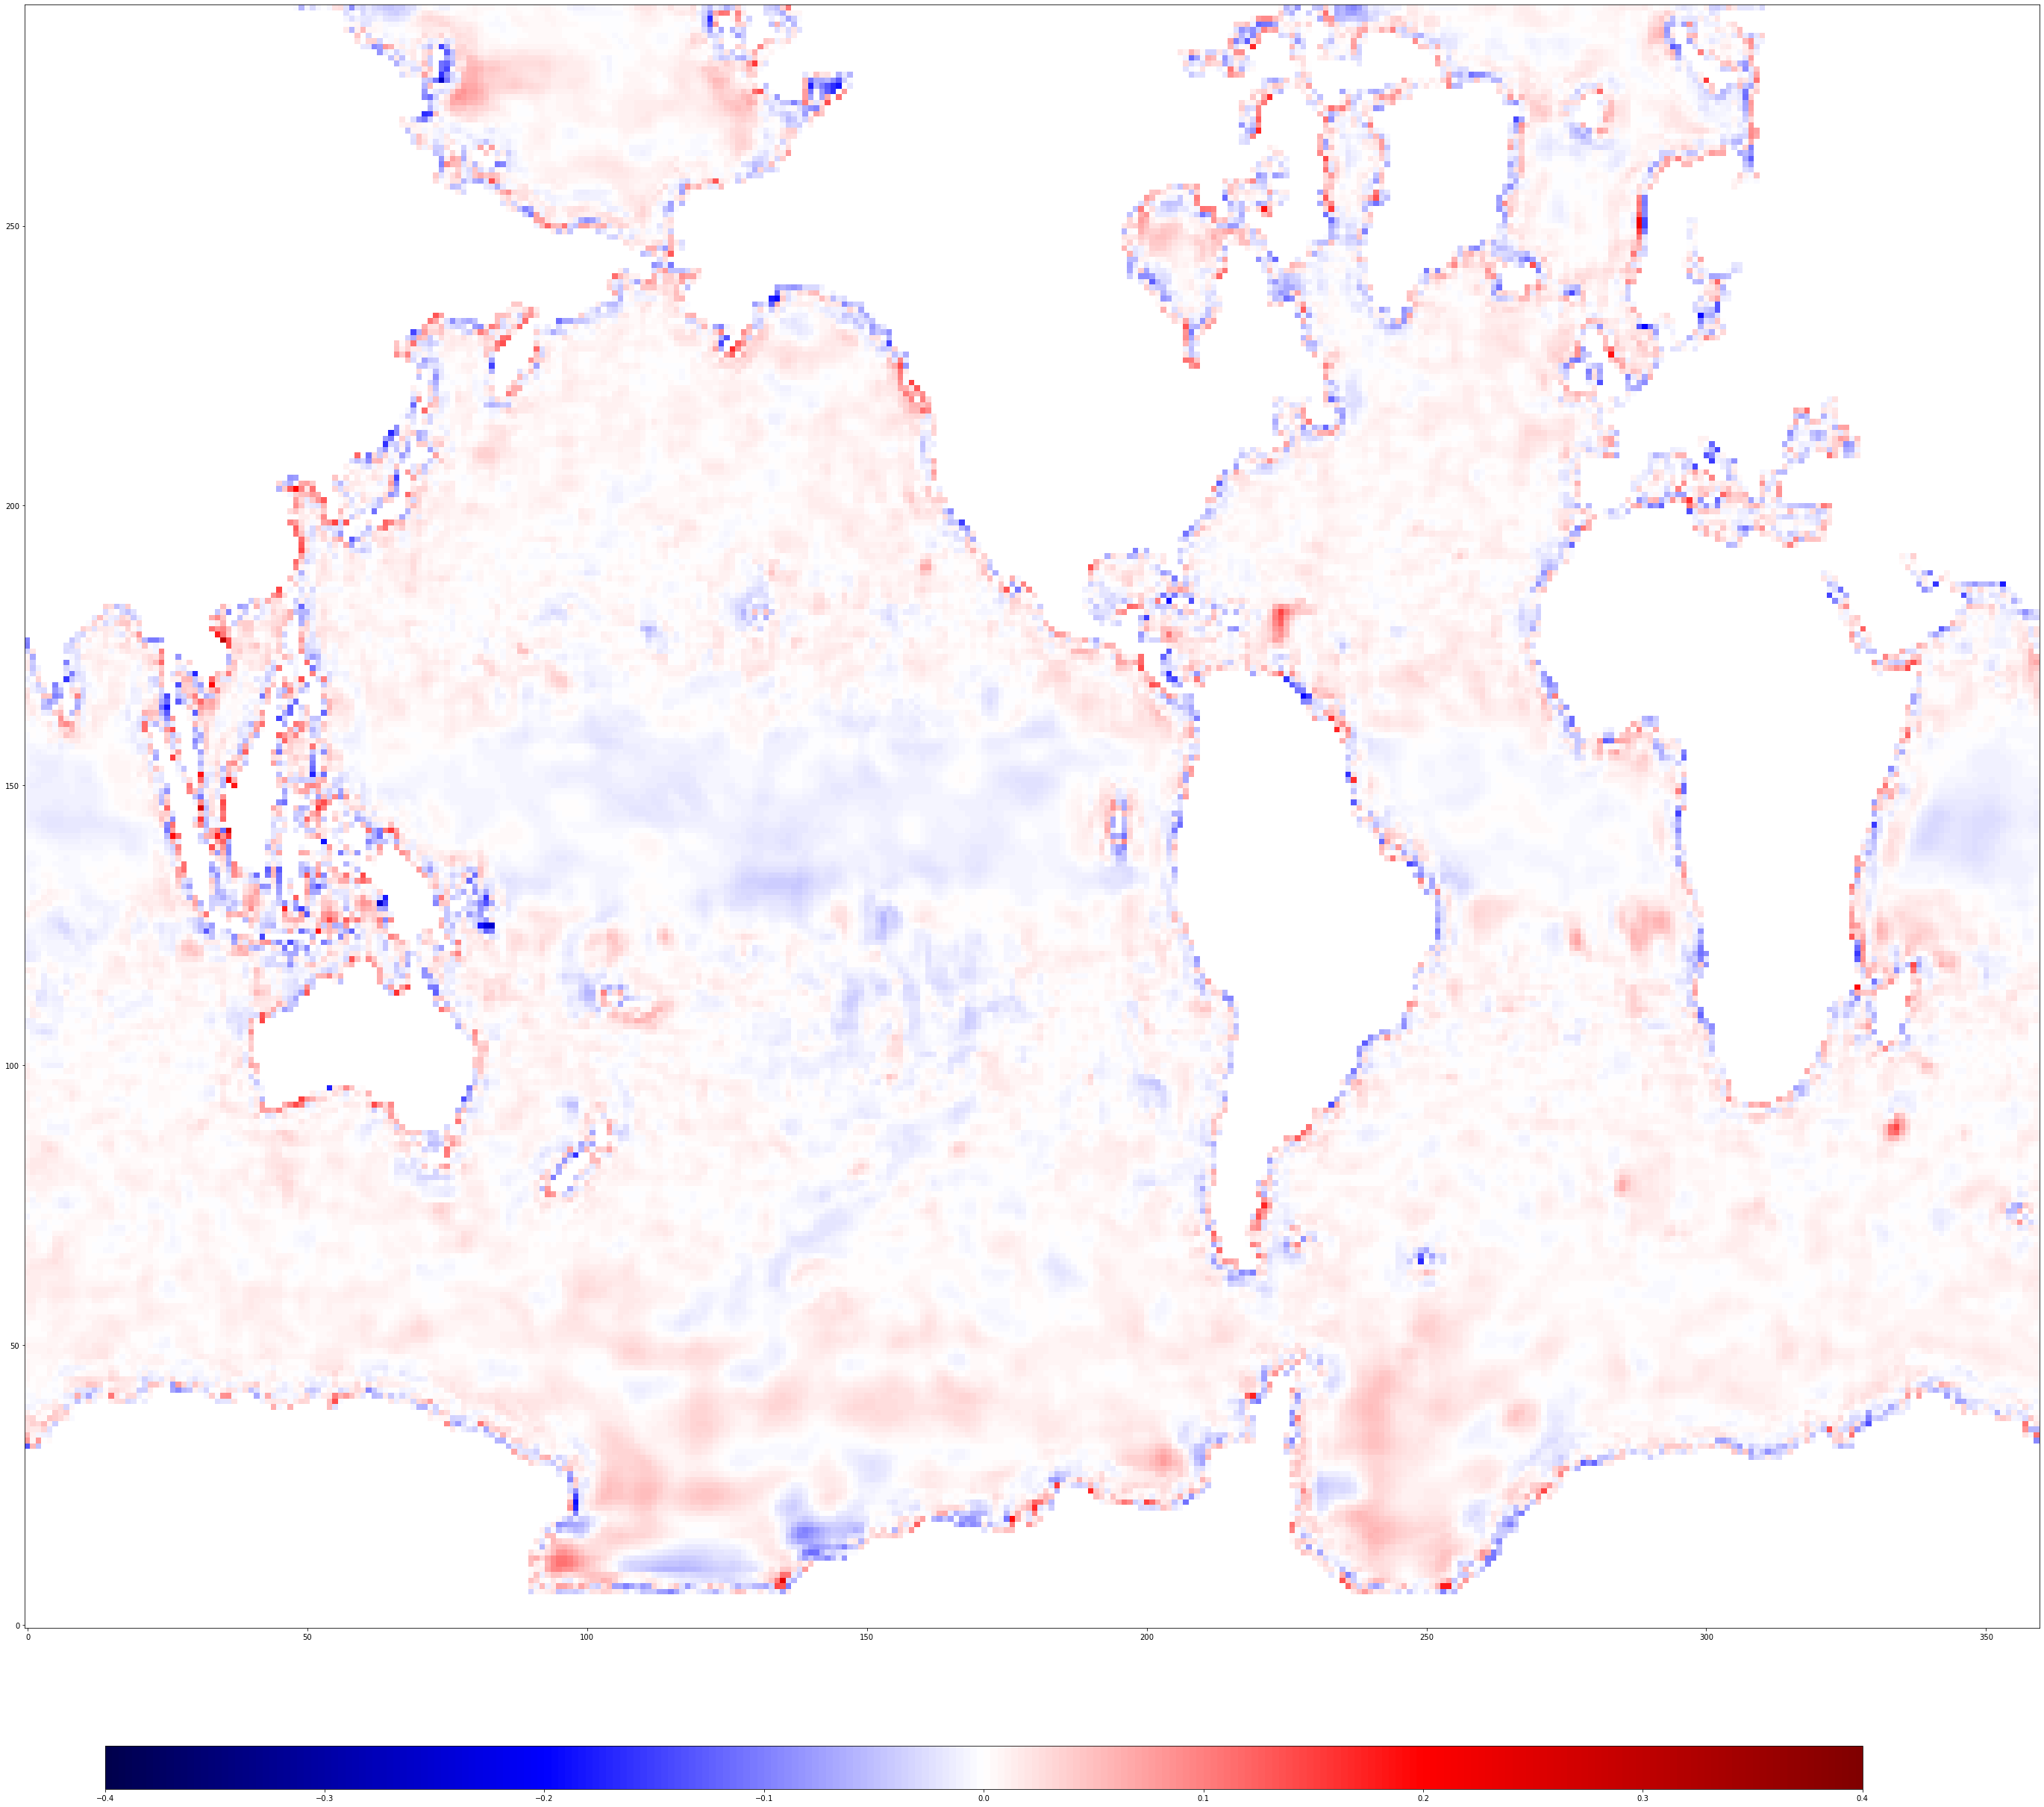

In [17]:
eps = compute_eps(X_valid,Y_valid,model_path,True,distance_map)
fig,axs = plt.subplots(figsize=size_im,ncols=1)
c = axs.imshow(eps,origin="lower",vmin=-0.4,vmax=0.4,cmap="seismic")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()
fig.savefig(save_dir+"valid/"+"1_1_eps_adamax_map")

In [18]:
m= np.load("data/sign_distance_map.npy")

In [19]:
np.max(m),np.min(m)

(61, -78)

In [20]:
model_path = "results/wandb/cnn/1_1_adam_map_std/checkpoints/epoch=49475-val_loss=0.00031.ckpt"
eps = compute_eps(X_train,Y_train,model_path,True,distance_map_std)
fig,axs = plt.subplots(figsize=size_im,ncols=1)
c = axs.imshow(eps,origin="lower",vmin=-0.05,vmax=0.05,cmap="seismic")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()
fig.savefig(save_dir+"train/"+"1_1_adam_map_std")

RuntimeError: Error(s) in loading state_dict for CNN:
	size mismatch for layers.0.0.weight: copying a param with shape torch.Size([32, 4, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 4, 3, 3]).
	size mismatch for layers.0.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.0.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.0.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.0.1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.0.1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.1.0.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for layers.1.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.1.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.1.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.1.1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.1.1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.2.0.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for layers.2.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.2.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.2.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.2.1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.2.1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.3.0.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for layers.3.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.3.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.3.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.3.1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.3.1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.4.0.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for layers.4.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.4.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.4.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.4.1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.4.1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.5.0.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for layers.5.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.5.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.5.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.5.1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.5.1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.6.0.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for layers.6.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.6.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.6.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.6.1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.6.1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.7.0.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for layers.7.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.7.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.7.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.7.1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.7.1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.8.0.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for layers.8.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.8.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.8.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.8.1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.8.1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layers.9.0.weight: copying a param with shape torch.Size([1, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 64, 3, 3]).

In [21]:
distance_map_std.shape

(310, 380)

In [22]:
X_train = transfrom(np.load(data_dir+"train/X/NORSSH_BND_PERTEN84.npz")['arr_0'])

In [23]:
w= X_train[2]

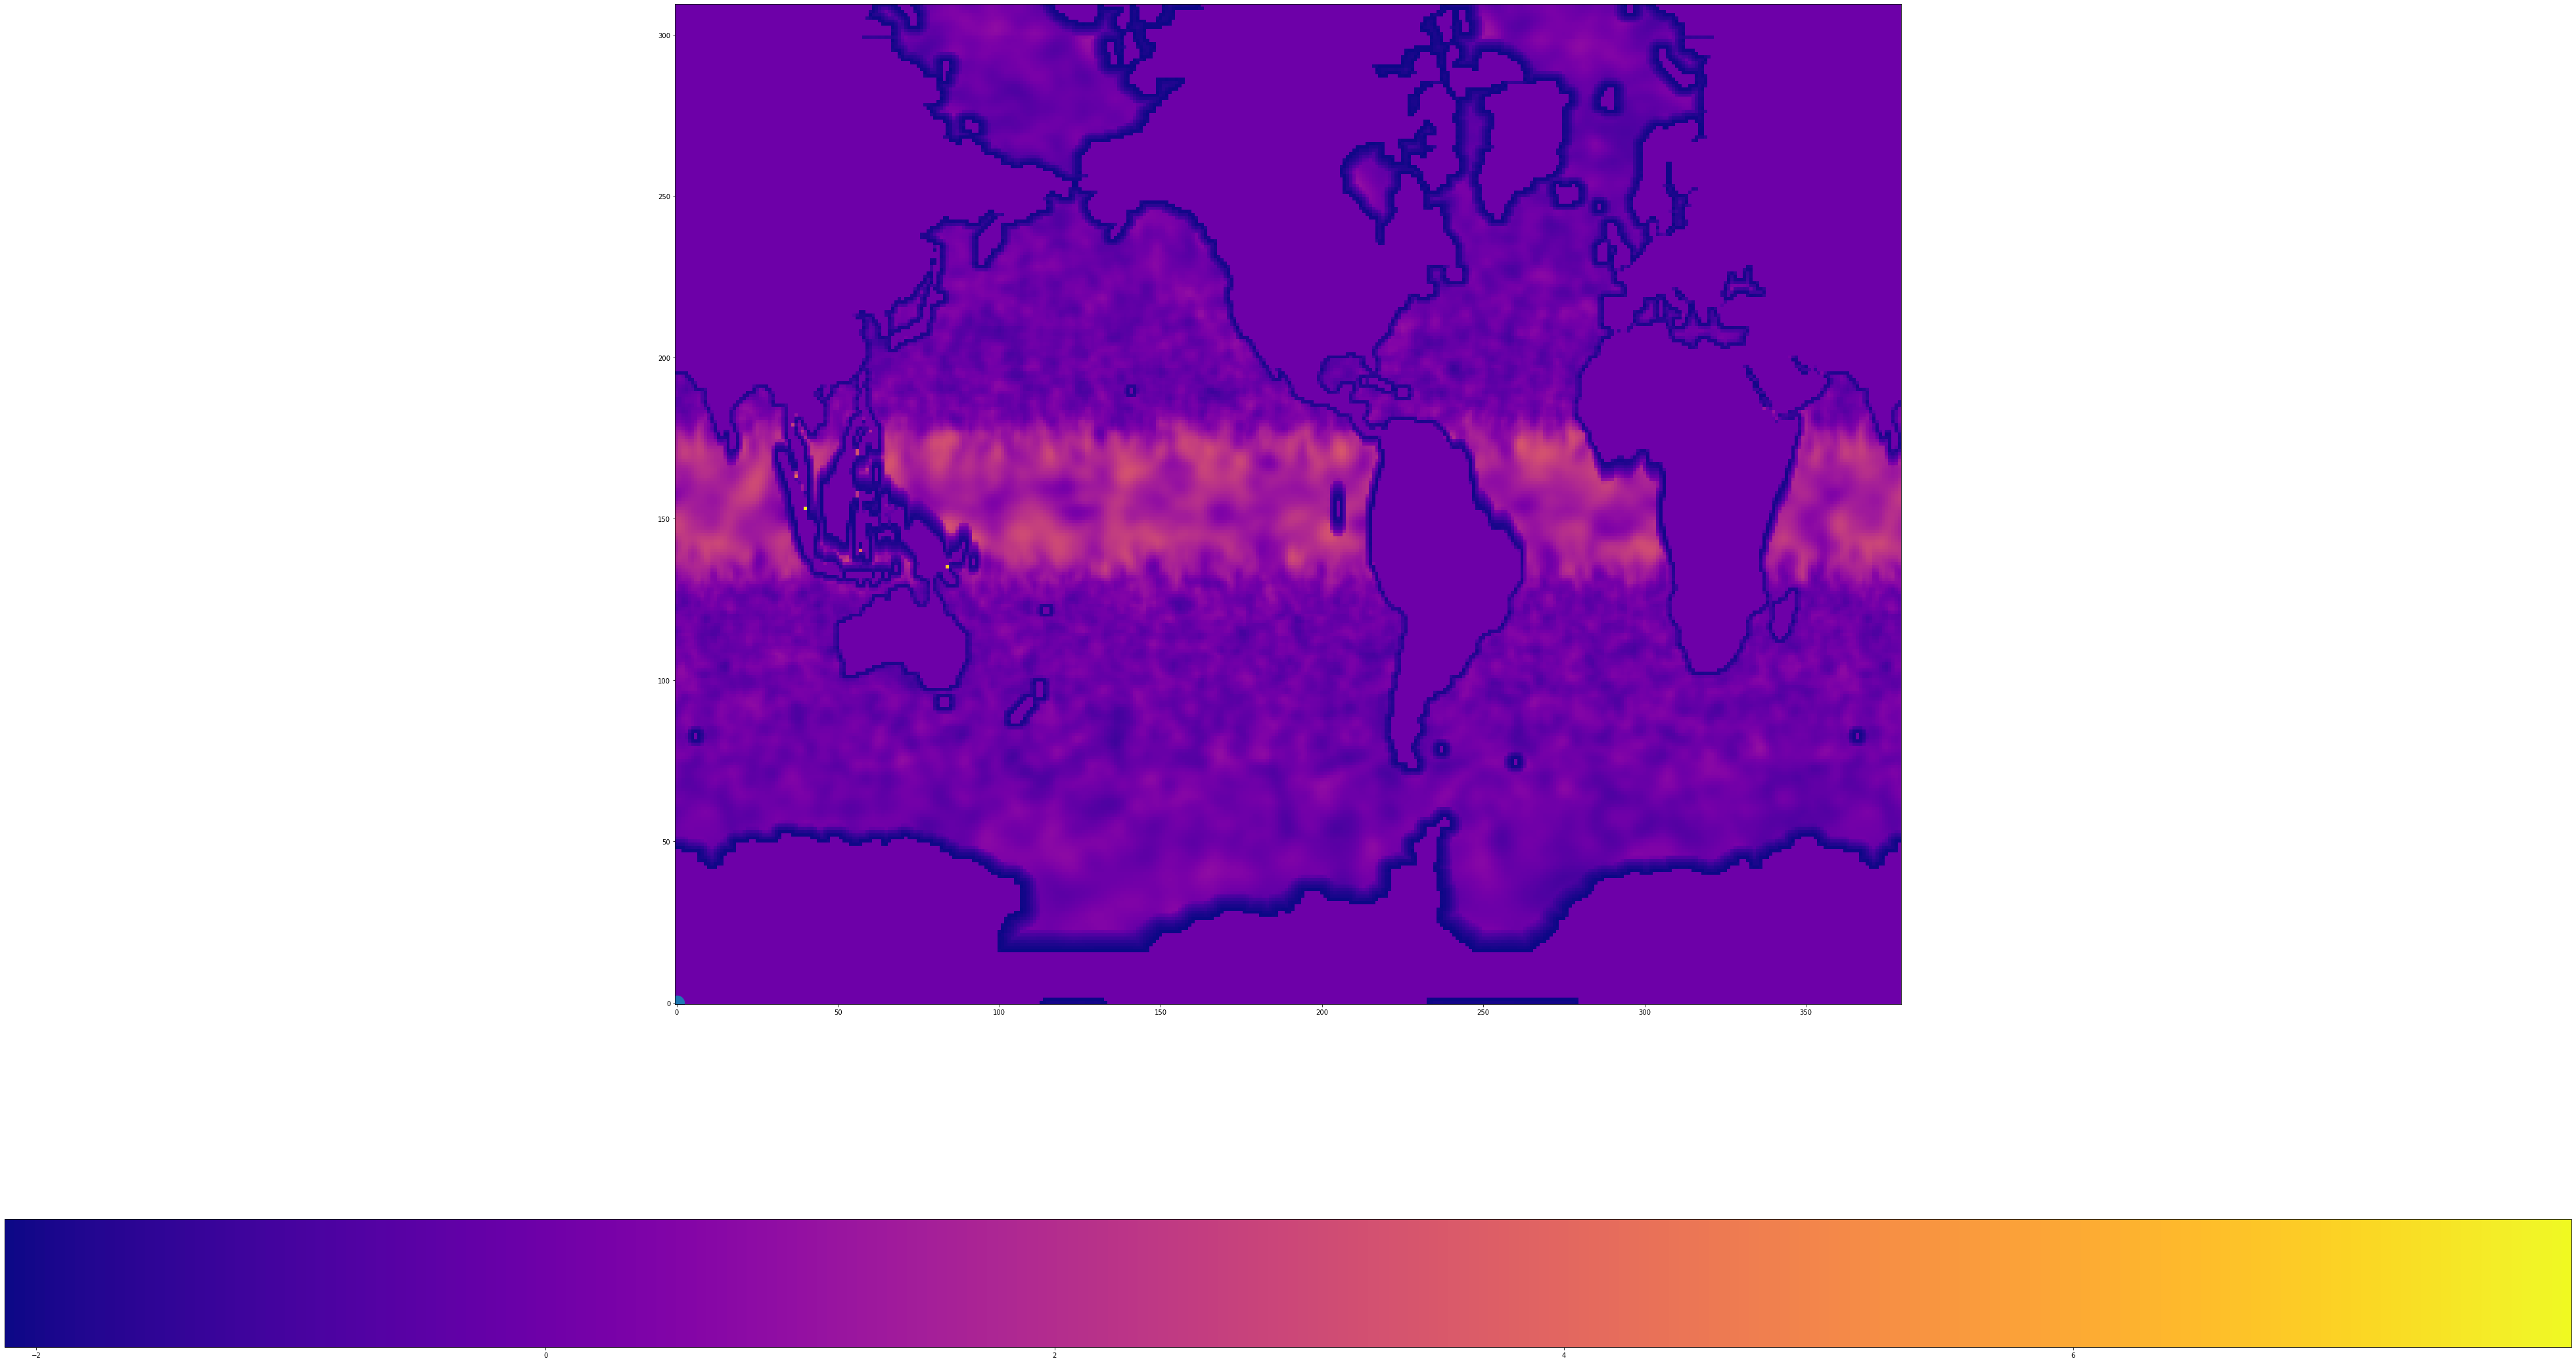

In [42]:
fig,axs = plt.subplots(figsize=size_im,ncols=1)
c = axs.imshow(X_train[0],origin="lower",cmap="plasma")
axs.scatter(0,0, s=500)
plt.colorbar(c,orientation='horizontal')
plt.show()


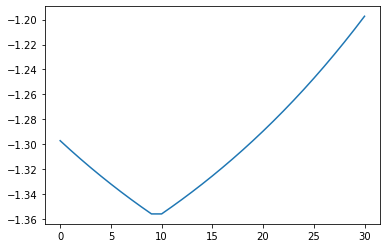

In [39]:
plt.plot(X_train[2,:31,0])